# Questions
se ci consigliano di rifare la pulizia dei dati perchè alcuni fanno cose strane o se lasciar perdere
se hanno altri dataset annotati (quello sul karate)

# Libraries installation on the current python environment

In [36]:
try:
    import networkx 
except:
    %pip install networkx==3.1
    %pip install numpy==1.23.5
    %pip install pandas==2.0.3
    %pip install pillow==10.0.0
    %pip install scikit-learn==1.3.0
    %pip install scipy==1.11
    %pip install matplotlib==3.7.1
    %pip isntall matplotlib-inline==0.1.6

# WORKING

Reading data from cleaned
```
TODO Manca muriel t_006 and t_008
Bisogna pulire ulteriormente i dati perchè il lavoro sembra non essere stato fatto bene (PI potrebbe impattare, I impatta, NI non impatta, R risolvibile, NR non risolvibile):
    - 3 PI | NR
    - 5 I | R
    - 7 I | R (la joint va fixata sul tricipite ma viene misinterpretata come una mano)
    - 8 I | R
    - 9 I | R (potrebbe essere complicato)
    - 13 PI ? | R : è ruotato di 45 gradi e potrebbe overfittare sul disallineamento trovando correlazione spuria per le etichette dei movimenti bassi del corpo (cora t_0028_3)
    - 14 stesso di 13 e sempre movimenti di gambe
    - 17 NI | R testa disallineata
    - 18 come 17 e potrebbe essere utile mappare la camminata come non OoM in entrambe le direzioni, ora son riuscito solo a farlo andare da sinistra a destra e ruotato come in direzione entrante
    - 19/20/21/22/23/24/25/26/27/28/29/30/31 come 17
    - da 25 i dispari sono specchiati e dovrebbero essere girati frontali
    - 27 I | R due joints nelle ginocchia e la spalla sinistra vanno fuori, ci vuole una constraint che faccia da interpolazione sulla distanza dalle due adiacenti
    - 33 I | R (?) ginocchio e pezzi di braccia volano via
    - 34 I | R gomito da lontano si riavvicina
    - 35 I | Difficilmente risolvibile, molto complesso... vanno via un sacco di cose

[ Probabilmente la strada migliore consiste nel prendere il 97.5% della coda destra di velocità e accelerazione per gran parte di questi e sostituire con la media di velocità e accelerazione le giunture limitrofe a quelle che stanno sopra la soglia
Ma bisogna prima metterle su dei grafici per controllare di non star tagliando fuori parti importanti 
Alternativa è riposizionare le anomalie con la regola 97.5% (o più) e calcolare le velocità in un secondo momento ] TODO se c'è tempo
```

In [37]:
import pandas as pd

DATA_POSITION_PATH = "data/position/"
DATA_DERIVATED_PATH = "data/derivated/"
MURIEL_POS = DATA_POSITION_PATH+"muriel/"
MARIANNE_POS = DATA_POSITION_PATH+"marianne/"
CORA_POS = DATA_POSITION_PATH+"cora/"
JUL_SEV_POS = DATA_POSITION_PATH+"07-07/"
JUL_EI_POS = DATA_POSITION_PATH+"07-08/"
JUL_THI_POS = DATA_POSITION_PATH+"07-13/"

# mappings are index -> (file_path, start_end_segment_tuple) in seconds
# TODO movements directions could be set consistently but in trials 1 -> 24 are in a way, while 25 to 36 are flipped, could set everything frontal
# TODO distibution of position should be normalized (maybe)
drivePosMap = { 1:  (MURIEL_POS+"t_003_finalclean.tsv",(37,40.5)),        
                2:  (MURIEL_POS+"t_003_finalclean.tsv",(58,64)),        
                3:  (MURIEL_POS+"t_003_finalclean.tsv",(73,76)),
                4:  (MURIEL_POS+"t_004_finalclean.tsv",(13,16)),
                5:  (MARIANNE_POS+"t_002_finalclean.tsv",(36.3,41.5)),
                6:  (MARIANNE_POS+"t_002_finalclean.tsv",(44.4,50)),
                7:  (MARIANNE_POS+"t_003_finalclean.tsv",(3,8.9)),
                8:  (MARIANNE_POS+"t_005_finalclean.tsv",(4,9)),
                9:  (MARIANNE_POS+"t_005_finalclean.tsv",(9.2,13.4)),
                10: (MARIANNE_POS+"t_012_finalclean.tsv",(14,20.1)),
                11: (CORA_POS+"t_028_finalclean.tsv",(4.7,8.3)),
                12: (CORA_POS+"t_028_finalclean.tsv",(12.8,18.5)),
                13: (CORA_POS+"t_028_finalclean.tsv",(24.2,29.7)),
                14: (CORA_POS+"t_028_finalclean.tsv",(29.8,36.2)),
                15: (CORA_POS+"t_028_finalclean.tsv",(51.1,55)),
                16: (CORA_POS+"t_028_finalclean.tsv",(57.9,63.8)),
                17: (JUL_SEV_POS+"t_051_finalclean.tsv",(16.9,18.7)),
                18: (JUL_SEV_POS+"t_052_finalclean.tsv",(11.5,13.2)),
                19: (JUL_SEV_POS+"t_052_finalclean.tsv",(15,18)),
                20: (JUL_SEV_POS+"t_052_finalclean.tsv",(19,21.5)),
                21: (JUL_SEV_POS+"t_060_finalclean.tsv",(2.6,5)),
                22: (JUL_SEV_POS+"t_061_finalclean.tsv",(58,61)),
                23: (JUL_SEV_POS+"t_063_finalclean.tsv",(25.5,28.5)),
                24: (JUL_SEV_POS+"t_064_finalclean.tsv",(2.5,5.5)),
                
                # TODO all these following have a problem with the head position and many with some joints going crazy
                # A_B trials maybe should be turned in front instead of on a side for consistency
                25: (JUL_EI_POS+"t_052_A_finalclean.tsv",(8.1,11.8)),       # ball catch left side
                26: (JUL_EI_POS+"t_052_B_finalclean.tsv",(11.8,15.1)),      # ball catch right side
                27: (JUL_EI_POS+"t_052_A_finalclean.tsv",(12.15,14.7)),     # ball throw left side
                28: (JUL_EI_POS+"t_052_B_finalclean.tsv",(8.5,11.8)),       # ball throw right side
                29: (JUL_EI_POS+"t_053_A_finalclean.tsv",(22,24.5)),        # ball high throw left side
                30: (JUL_EI_POS+"t_053_B_finalclean.tsv",(22,24.5)),        # ball side catch right side
                31: (JUL_EI_POS+"t_053_A_finalclean.tsv",(25,27.2)),        # ball throw left side
                32: (JUL_EI_POS+"t_053_B_finalclean.tsv",(25,27.2)),        # ball catch right side
                33: (JUL_THI_POS+"t_061_A_finalclean.tsv",(29,32.1)),       # ball throw cheat left side
                34: (JUL_THI_POS+"t_061_B_finalclean.tsv",(29,32.1)),       # ball catch right side TODO error in joint 
                35: (JUL_THI_POS+"t_061_A_finalclean.tsv",(74,80)),         # right ball catch left side TODO many joints going crazy
                36: (JUL_THI_POS+"t_061_B_finalclean.tsv",(74,80))          # ball catch right side
              }

picked = 1

data = drivePosMap[picked]
table = pd.read_table(data[0])
table.head()

,Time,left_foot_X,left_foot_Y,left_foot_Z,right_foot_X,right_foot_Y,right_foot_Z,left_ankle_X,left_ankle_Y,left_ankle_Z,...,left_shoulder_Z,shoulder_center_X,shoulder_center_Y,shoulder_center_Z,right_shoulder_X,right_shoulder_Y,right_shoulder_Z,head_X,head_Y,head_Z
0,0.00000,0.880078,0.005587,0.003165,0.890875,0.003183,-0.219213,0.955926,0.076895,0.035329,...,0.051810,0.951091,1.354649,-0.089303,0.971931,1.351419,-0.230416,0.921563,1.560234,-0.094183
1,0.01042,0.880026,0.005624,0.003019,0.890553,0.003508,-0.219397,0.955918,0.076906,0.035318,...,0.051775,0.951122,1.354691,-0.089327,0.971946,1.351445,-0.230429,0.921630,1.560252,-0.094193
2,0.02083,0.879969,0.005662,0.002873,0.890258,0.003751,-0.219501,0.955908,0.076915,0.035303,...,0.051740,0.951150,1.354736,-0.089351,0.971961,1.351480,-0.230442,0.921697,1.560268,-0.094201
3,0.03125,0.879907,0.005704,0.002734,0.890010,0.003858,-0.219486,0.955896,0.076923,0.035283,...,0.051706,0.951176,1.354786,-0.089374,0.971978,1.351534,-0.230453,0.921759,1.560279,-0.094205
4,0.04167,0.879844,0.005746,0.002612,0.889819,0.003826,-0.219372,0.955884,0.076930,0.035259,...,0.051673,0.951200,1.354842,-0.089396,0.971996,1.351612,-0.230465,0.921815,1.560285,-0.094202


In [38]:
startEndSeconds = data[1]
posTable = table[table["Time"].between(startEndSeconds[0],startEndSeconds[1])].iloc[:,1:]

if 1 <= picked <= 10:
    posTableY = posTable.iloc[:,::3]
    posTableZ = posTable.iloc[:,1::3]
    posTableX = posTable.iloc[:,2::3]
elif 11 <= picked <= 16:
    posTableX = posTable.iloc[:,::3]
    posTableZ = posTable.iloc[:,1::3]
    posTableY = posTable.iloc[:,2::3]
elif (17 <= picked <= 20 and picked != 19) or picked >= 25:
    posTableY = posTable.iloc[:,::3]
    posTableX = posTable.iloc[:,1::3]
    posTableZ = posTable.iloc[:,2::3]
else:
    posTableX = posTable.iloc[:,::3]
    posTableY = posTable.iloc[:,1::3]
    posTableZ = posTable.iloc[:,2::3]

posTableX = posTableX.rename(columns=dict(zip(list(posTableX),[name.replace('Z','X').replace('Y','X') for name in list(posTableX)])))
posTableY = posTableY.rename(columns=dict(zip(list(posTableY),[name.replace('Z','Y').replace('X','Y') for name in list(posTableY)])))
posTableZ = posTableZ.rename(columns=dict(zip(list(posTableZ),[name.replace('X','Z').replace('Y','Z') for name in list(posTableZ)])))

#theta = np.pi/2  # 90 degrees in radians
#R = np.array([[np.cos(theta), -np.sin(theta), 0],
#              [np.sin(theta), np.cos(theta), 0],
#              [0, 0, 1]])

#for i in range(len(tableX)):
#    # Apply the rotation matrix to the data
#    data_st = np.vstack([tableX.iloc[i,:], tableY.iloc[i,:], tableZ.iloc[i,:]])
#    data_rotated = np.dot(data_st, R)
#    tableX[i,:]=data_rotated[0,:]
#    tableY[i,:]=data_rotated[1,:]
#    tableZ[i,:]=data_rotated[2,:]    
#tableX = data_rotated[:,0]
#tableY = data_rotated[:,1]
#tableZ = data_rotated[:,2]

In [39]:
from matplotlib import pyplot as plt
%matplotlib
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


plt.close("all")
fig = plt.figure()
ax:plt.Axes = fig.add_subplot(111, projection='3d')


minMax = np.zeros((2,3))
minMax[0,:] = [posTableX.values.min(),posTableY.values.min(),posTableZ.values.min()]
minMax[1,:] = [posTableX.values.max(),posTableY.values.max(),posTableZ.values.max()]

print(minMax)

# Set appropriate axis limits
ax.set_xlim([minMax[0,0],minMax[1,0]])
ax.set_ylim([minMax[0,1],minMax[1,1]])
ax.set_zlim([minMax[0,2],minMax[1,2]])

# Set the window title
fig.canvas.manager.window.title("3D Movement\t(Scroll with mouse wheel)")

# Set the initial time index
time_index = 0
colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'cyan']

# Function to update the plot based on the slider value
def update_plot(val):
    ax.cla()  # Clear the previous plot
    
    # Filter the data based on the current time index
    filteredX = posTableX.iloc[val]
    filteredY = posTableY.iloc[val]
    filteredZ = posTableZ.iloc[val]
    
    ax.scatter(filteredX,filteredY,filteredZ,c=colors[:4]*5)

    ax.set_xlim([minMax[0,0],minMax[1,0]])
    ax.set_ylim([minMax[0,1],minMax[1,1]])
    ax.set_zlim([minMax[0,2],minMax[1,2]])
    
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)
    ax.set_title("Movement "+str(picked))

    fig.canvas.draw_idle()

# Create a slider widget
slider_ax = plt.axes([0.2, 0.03, 0.6, 0.03])
maxValue = posTable.shape[0]-1
slider = Slider(slider_ax, 'TimeIndex:', 0, maxValue, valinit=time_index, valstep=1)


# Define a function to update the slider value with the mouse wheel
def on_scroll(event):
    if event.button == 'down':
        if slider.val + slider.valstep*2 <= maxValue:
            slider.set_val(slider.val + slider.valstep*2)
    elif event.button == 'up':
        if slider.val - slider.valstep*2 >= 0:
            slider.set_val(slider.val - slider.valstep*2)
        

# Connect the mouse wheel event to the function
fig.canvas.mpl_connect('scroll_event', on_scroll)


# Register the update_plot function with the slider widget
slider.on_changed(update_plot)

# Initial plot
update_plot(time_index)

# Show the plot
plt.show()


Using matplotlib backend: TkAgg
[[-0.78655715 -0.00617931  0.00219524]
 [ 0.57748145  1.45234593  2.0124404 ]]


In [40]:
plt.close('all')

## Calculating features based on the version: sample matlab code for origin of movement

### Calculating speed, acceleration, energy, angular momentum features

Sure! Here's the table with the explanations in markdown format:

|Function | Input | Output | Explanation  |
|---------|-------|--------|--------------|
| `group_table_by_joints` | table (pd.DataFrame)         | table (pd.DataFrame) | Takes a DataFrame with X,Y,Z values for every joint as columns and groups the data for each joint into a single column made of a list(X,Y,Z). |
| `group_table_by_jointsV2` | table (pd.DataFrame)       | table (pd.DataFrame) | Same as version 1 but in a more optimized way (TODO must be checked)  |
| `joints_array_to_xyz_columns` | table (pd.DataFrame)         | table (pd.DataFrame) | Inverse of `group_table_by_joints`. Further explanation: Takes a DataFrame with joint-wise columns and transforms it into a new DataFrame with separate columns for X, Y, and Z coordinates for each joint. It creates new columns by expanding the lists in each joint's column into individual rows. |
| `table_to_list_xyz_tables` | table (pd.DataFrame)         | tuple (pd.DataFrame, pd.DataFrame, pd.DataFrame) | Splits the input DataFrame into three separate DataFrames representing X, Y, and Z coordinates of all joints. The output DataFrames contain the columns for each joint's respective coordinate. |
| `xyz_tables_to_xyz_columns` | tuple (pd.DataFrame, pd.DataFrame, pd.DataFrame) | table (pd.DataFrame) | inverse of `table_to_list_xyz_tables`. Further explanation: Takes the three separate DataFrames containing X, Y, and Z coordinates of all joints and merges them into a new DataFrame. The resulting DataFrame has separate columns for X, Y, and Z coordinates for each joint. |
| `movmean`               | x (pd.Series or 1D array)   | pd.Series        | Calculates the moving average of the input data using a window of size  ***w***. The moving average is computed at each position of the input data, resulting in a new pandas Series with the moving average values. |
| `movmedian`             | x (pd.Series or 1D array)   | 1D array         | Calculates the moving median of the input data using a window of size ***w***. The moving median is computed at each position of the input data, resulting in a new 1D array with the moving median values. |
| `smoothing`             | x (pd.DataFrame)            | pd.DataFrame     | Applies smoothing to the input DataFrame using the `movmedian` with ***w=5*** and `movmean` with ***w=25*** for each column in the DataFrame. |
| `compute_derivatives`   | x (pd.DataFrame), dt (float), smooth (bool) | pd.DataFrame | Calculates the derivatives of joint positions in the x DataFrame with respect to a deltaTime. Formula: *v = dx/dt*. If smooth the derivative is passed through `smoothing` |

In [41]:
import pandas as pd

################### remapping dataframes
def group_table_by_joints(table: pd.DataFrame) -> pd.DataFrame:
    columns = [col.replace('_X','') for col in list(table.columns)[::3]]
    result = pd.DataFrame(columns=columns)
    for j in range(0,table.shape[1],3):
        lst = []
        for i in range(table.shape[0]):
            lst.append(table.iloc[i,j:j+3].values)
        result[columns[int(j/3)]] = lst
    return result

# TODO OTTIMIZZAZIONE se c'è tempo
def group_table_by_jointsV2(table: pd.DataFrame) -> pd.DataFrame:
    # Get unique joint names by removing '_X' from column names
    columns = [col.replace('_X', '') for col in table.columns[::3]]

    # Group the DataFrame by joint name and aggregate the grouped values as lists
    result = table.groupby([col.replace('_X', '') for col in table.columns], axis=1).agg(lambda x: x.values.tolist())

    # Rename the columns to match the joint names
    result.columns = columns

    return result


def joints_array_to_xyz_columns(table: pd.DataFrame) -> pd.DataFrame:
    return pd.concat([table[column].apply(lambda row: pd.Series(row,index=[column+'_X',column+'_Y',column+'_Z'])) for column in table.columns],axis=1)
    
def table_to_list_xyz_tables(table:pd.DataFrame,into="xyz"):
    if into == "xyz":
        return table.iloc[:,::3],table.iloc[:,1::3],table.iloc[:,2::3]
    elif into == "points":
        return [table.iloc[:,j:j+3] for j in range(0,table.shape[1],3)]

def xyz_tables_to_xyz_columns(tablesList):
    xTable,yTable,zTable = tablesList
    mergedTable = pd.DataFrame()
    for joint in range(xTable.shape[1]):
        mergedTable = pd.concat([mergedTable,xTable.iloc[:,joint],yTable.iloc[:,joint],zTable.iloc[:,joint]],axis=1)
    return mergedTable
####################


#################### reproducing MATLAB movmean and movmedian
def movmean(x, w):
    return pd.Series(x).rolling(window=w,min_periods=1,center=True).mean()

from scipy.signal import medfilt
def movmedian(x,w):
    return np.concatenate([np.convolve(x[:w-1], np.ones(w-1), 'valid') / (w-1),medfilt(x,w)[1:-1],np.convolve(x[-w+1:], np.ones(w-1), 'valid') / (w-1)])
###################

################### features computation
def smoothing(x: pd.DataFrame) -> pd.DataFrame:
    return x.apply(lambda col: movmedian(col,5)).apply(lambda col: movmean(col,25))
    
def compute_derivatives(x:pd.DataFrame,dt:float,smooth=True) -> pd.DataFrame:
    v : pd.DataFrame
    v = x.diff() / dt
    v = v.fillna(v.iloc[1:10,:].mean())
    return smoothing(v) if smooth else v
###################

In [42]:
#timeCol = table[table["Time"].between(startEndSeconds[0],startEndSeconds[1])]["Time"]
dt = ((startEndSeconds[1]-startEndSeconds[0]) / len(posTable))
velocityTable = compute_derivatives(posTable,dt)
velocityTable = group_table_by_joints(velocityTable).applymap(lambda x: np.linalg.norm(x))
velocityTable.head()

,left_foot,right_foot,left_ankle,right_ankle,left_knee,right_knee,left_hip,hip_center,right_hip,spine,left_hand,right_hand,left_wrist,right_wrist,left_elbow,right_elbow,left_shoulder,shoulder_center,right_shoulder,head
0,0.000310,0.000131,0.001727,0.008840,0.002583,0.001003,0.006632,0.006379,0.011903,0.008936,0.034680,0.138155,0.038058,0.153504,0.041735,0.123398,0.009968,0.026503,0.053291,0.002928
1,0.000352,0.000097,0.001748,0.008404,0.002727,0.001861,0.006372,0.006413,0.011663,0.009169,0.034201,0.145195,0.038581,0.161161,0.042011,0.128471,0.010600,0.027487,0.055524,0.002856
2,0.000392,0.000117,0.001776,0.008039,0.002908,0.002772,0.006117,0.006461,0.011513,0.009466,0.033780,0.152317,0.039189,0.169234,0.042332,0.133757,0.011294,0.028580,0.058068,0.002827
3,0.000430,0.000202,0.001811,0.007748,0.003101,0.003651,0.005871,0.006542,0.011510,0.009829,0.033436,0.159383,0.039877,0.177699,0.042703,0.139337,0.012049,0.029789,0.060934,0.002834
4,0.000465,0.000316,0.001851,0.007520,0.003297,0.004431,0.005632,0.006743,0.011657,0.010245,0.033189,0.166335,0.040636,0.186515,0.043127,0.145275,0.012861,0.031120,0.064129,0.002875


#### Calculating energy
*E = 1/2 m v^2* \
*m = 1*

In [43]:
energyTable = 0.5 * velocityTable**2    # unitary mass
energyTable.head()

,left_foot,right_foot,left_ankle,right_ankle,left_knee,right_knee,left_hip,hip_center,right_hip,spine,left_hand,right_hand,left_wrist,right_wrist,left_elbow,right_elbow,left_shoulder,shoulder_center,right_shoulder,head
0,4.816464e-08,8.623273e-09,0.000001,0.000039,0.000003,5.025495e-07,0.000022,0.000020,0.000071,0.000040,0.000601,0.009543,0.000724,0.011782,0.000871,0.007614,0.000050,0.000351,0.001420,0.000004
1,6.187164e-08,4.694889e-09,0.000002,0.000035,0.000004,1.731326e-06,0.000020,0.000021,0.000068,0.000042,0.000585,0.010541,0.000744,0.012986,0.000882,0.008252,0.000056,0.000378,0.001541,0.000004
2,7.688229e-08,6.902434e-09,0.000002,0.000032,0.000004,3.843115e-06,0.000019,0.000021,0.000066,0.000045,0.000571,0.011600,0.000768,0.014320,0.000896,0.008945,0.000064,0.000408,0.001686,0.000004
3,9.235716e-08,2.030866e-08,0.000002,0.000030,0.000005,6.664901e-06,0.000017,0.000021,0.000066,0.000048,0.000559,0.012701,0.000795,0.015789,0.000912,0.009707,0.000073,0.000444,0.001856,0.000004
4,1.081962e-07,4.986205e-08,0.000002,0.000028,0.000005,9.816206e-06,0.000016,0.000023,0.000068,0.000052,0.000551,0.013834,0.000826,0.017394,0.000930,0.010552,0.000083,0.000484,0.002056,0.000004


In [44]:
accelerationTable = compute_derivatives(velocityTable,dt)
accelerationTable.head()

,left_foot,right_foot,left_ankle,right_ankle,left_knee,right_knee,left_hip,hip_center,right_hip,spine,left_hand,right_hand,left_wrist,right_wrist,left_elbow,right_elbow,left_shoulder,shoulder_center,right_shoulder,head
0,0.003089,0.012876,0.004001,-0.015360,0.015807,0.049115,0.043464,0.053989,0.019028,0.046118,0.006090,0.682239,0.084204,0.939622,0.056760,0.685559,0.095921,0.153388,0.378949,0.004821
1,0.003140,0.013574,0.003942,-0.014657,0.015220,0.049030,0.049203,0.056671,0.022608,0.050438,0.011843,0.725038,0.090058,1.014478,0.062870,0.745192,0.105512,0.163719,0.408232,0.004511
2,0.003184,0.014180,0.003784,-0.014206,0.014550,0.049031,0.051791,0.060173,0.029599,0.055398,0.018619,0.771518,0.096120,1.093123,0.069475,0.807308,0.116152,0.173760,0.437923,0.004040
3,0.003223,0.014709,0.003425,-0.013914,0.013344,0.049181,0.052726,0.065115,0.040687,0.060801,0.025767,0.819755,0.102191,1.169950,0.076722,0.866930,0.127768,0.183324,0.467581,0.003420
4,0.003240,0.014960,0.002896,-0.013847,0.011824,0.049408,0.052485,0.071811,0.056002,0.066782,0.033140,0.873308,0.108623,1.247223,0.084759,0.924933,0.140460,0.192794,0.497890,0.002681


#### Angular momentum with respect to the center of mass

* $\vec{s}_{\text{CM}} =  \frac{{\sum_{j=1}^{20} \vec{s}_{j}}}{{20}} $

* $\vec{s}_{r} =  \vec{s} - \vec{s}_{CM} $

* $\vec{v}_{\text{CM}} = \frac{\vec{ds}_{CM}}{dt}$

* $\vec{v}_{r} = \vec{v} - \vec{v}_{\text{CM}}$

* $\vec{L} = \vec{s}_{r} \times (\vec{v}_{r} * m) \quad with \ m = 1 $


In [45]:
centerOfMassPosTable = pd.concat([table.apply(lambda row: row.sum()/20,axis=1) for table in table_to_list_xyz_tables(posTable)],axis=1)
relativePosTable = group_table_by_joints(xyz_tables_to_xyz_columns([posTableAxis.subtract(centerOfMassPosTable.iloc[:,j],axis=0) for j,posTableAxis in enumerate(table_to_list_xyz_tables(posTable))]))
centerOfMassVelocityTable = compute_derivatives(centerOfMassPosTable,dt,smooth=False)
relativeVelocityTable = group_table_by_joints(xyz_tables_to_xyz_columns([velocityTableAxis.subtract(centerOfMassVelocityTable.iloc[:,j],axis=0) for j,velocityTableAxis in enumerate(table_to_list_xyz_tables(compute_derivatives(posTable,dt)))]))
angularMomentumTable = relativePosTable
relativePosTable.head()
for i in range(len(relativePosTable)):
    for j in range(len(relativePosTable.columns)):
        angularMomentumTable.iloc[i,j][:] = np.cross(relativePosTable.iloc[i,j],relativeVelocityTable.iloc[i,j])
angularMomentumTable = group_table_by_joints(smoothing(joints_array_to_xyz_columns(angularMomentumTable)))
angularMomentumTable.head()

,left_foot,right_foot,left_ankle,right_ankle,left_knee,right_knee,left_hip,hip_center,right_hip,spine,left_hand,right_hand,left_wrist,right_wrist,left_elbow,right_elbow,left_shoulder,shoulder_center,right_shoulder,head
0,"[0.003250247107973672, 0.002310663754554927, 0...","[0.0026326046872235474, -0.002824961237654393,...","[0.0029352854002208783, 0.0029678950686879662,...","[-0.0025163076905882027, -0.003948701175738521...","[0.0009834667871730035, 0.002015766616924319, ...","[0.00018656113779290785, -0.002783612301827241...","[-0.0003575602808102921, 0.0019707064602920163...","[1.3446134306370063e-05, 1.4976563707067157e-0...","[0.001264363748829257, -0.0019416827512988627,...","[-0.003276086014516251, 0.0010218625871743468,...","[0.0010055225930890282, 0.007613605517315495, ...","[-0.003927545566976862, 0.033526828970703505, ...","[-0.004037712290754298, 0.009186709046834404, ...","[0.002077775700543898, 0.04500786769685556, 0....","[-0.007370173446528234, 0.010331598013241681, ...","[0.0005132451326427589, 0.027841390896498404, ...","[0.00023010749198094287, 0.006246486276715656,...","[0.002878304207019141, 9.618601685576058e-06, ...","[0.006703681549610361, 0.008482139771081153, 0...","[-0.004799376399983091, 0.00039641264139301955..."
1,"[0.0036126067526575977, 0.002404923850133213, ...","[0.0030062078981249055, -0.0029742646108256066...","[0.0032589755420567817, 0.0031233886203859253,...","[-0.002219828890390469, -0.004088922369486191,...","[0.0011275337976312356, 0.002123507617477351, ...","[0.0003114573963820319, -0.0029053747221036152...","[-0.0003058721741110862, 0.0020597929985990983...","[1.0369753367650206e-05, 1.4804462178009611e-0...","[0.0011996297375242114, -0.002090533342815685,...","[-0.0035250363167358555, 0.0010983026150297038...","[0.000985975366816086, 0.007729101644307986, 0...","[-0.004164883230941596, 0.034120978805864094, ...","[-0.004017833322442074, 0.00950020787718001, -...","[0.002169000998895962, 0.04614598115866957, 0....","[-0.007411069669591514, 0.01073131735049142, -...","[0.0006599600828039398, 0.028518829597965308, ...","[0.00013075178127131505, 0.0065838307199127324...","[0.0028926998911653476, 1.3175682169755661e-05...","[0.006903199651572242, 0.00871277927614952, 0....","[-0.005156311375594948, 0.00041651832228581696..."
2,"[0.004009224637626659, 0.0024994176490389162, ...","[0.0034159518352785668, -0.0031284504652646706...","[0.003613314772615068, 0.0032834805733159907, ...","[-0.0018919017983747865, -0.004231916023327963...","[0.0012840145047761885, 0.002235695955913957, ...","[0.00044813156323294617, -0.003030291249115422...","[-0.0002610758149717744, 0.002155598180313088,...","[7.703556554092997e-06, 1.4637688063500343e-05...","[0.0011435269277265054, -0.002239509146134863,...","[-0.003803678841637271, 0.0011822999555722033,...","[0.0009621251180326136, 0.007848778648752792, ...","[-0.004417634790868433, 0.034802570686892645, ...","[-0.003996799912393254, 0.009833184493922509, ...","[0.002272416747500938, 0.0474458780244047, 0.0...","[-0.00745735951510898, 0.011154200862892026, -...","[0.0008567669331634244, 0.029299638092961797, ...","[1.6372187693899023e-05, 0.006944958992408335,...","[0.002909031116085097, 1.625848525604465e-05, ...","[0.007127382076856645, 0.008981492369079417, 0...","[-0.005540780457195169, 0.0004372619766354687,..."
3,"[0.004442670288257758, 0.002594288992573286, 0...","[0.00386303228610251, -0.003287724744344287, 0...","[0.0040008359476031785, 0.0034489185839049843,...","[-0.0015300909054227268, -0.004376882719155824...","[0.0014566945461603636, 0.0023529754398139958,...","[0.0005959203112199709, -0.0031583595238436936...","[-0.00022187900072487656, 0.002261013293847368...","[5.37063434223044e-06, 1.4491760713304734e-05,...","[0.0010944369691535125, -0.0023847034665592606...","[-0.004114650570159731, 0.001274526008876853, ...","[0.0009361316399293864, 0.007976546869837009, ...","[-0.004686828252301024, 0.035567919535558455, ...","[-0.003974387075589529, 0.01

### Calculating weight matrix from a feature

| Function | Input | Output | Explanation |
|----------|-------|--------|-------------|
| `calculate_weight_matrix` | featureTable (pd.DataFrame), adjacencyMatrix (np.ndarray), tol (float) | weight_matrix (np.ndarray) | Computes a weight matrix: if the feature is scalar (velocity, acceleration, energy) $\frac{1}{abs(x_{j}-x_{i})+tol}$ if theres an edge between *(i,j)* in the `adjacencyMatrix` otherwise it's $\frac{1}{5 * abs(x_{j}-x_{i})+tol}$. if the feature is vectorial (angular momentum) from the vectorial features a cross-product the Euclidean norms of the vector features and cross-products of these norms to generate norm_crossed_matrix. It also calculates dot-crossed products of the vector features. The weight matrix is constructed using the adjacency matrix, with edge weights depending on the dot-crossed products and the norm_crossed_matrix. Diagonal elements are set to zero. |

In [46]:
import pandas as pd
import numpy as np

def calculate_weight_matrix(featureTable: pd.DataFrame, adjacencyMatrix: np.ndarray,tol:float=None) -> np.ndarray:
    if isinstance(featureTable.iloc[0],np.ndarray):
        values = np.stack(featureTable.values)
        norm_matrix = np.linalg.norm(values, axis=1)
        norm_crossed_matrix = norm_matrix[:, None] * norm_matrix
        dot_crossed_matrix = np.dot(values, values.T)
        weight_matrix = np.where(adjacencyMatrix, dot_crossed_matrix / norm_crossed_matrix + 1, dot_crossed_matrix / (norm_crossed_matrix + 1) * 1/5)
    else:
        if tol is None:
            raise Exception('must provide tol value with scalar feature')
        diff_matrix = table.values[:, None] - table.values
        # norm matrix not needed since features in our case are already scalar
        norm_matrix = np.abs(diff_matrix) #np.linalg.norm(diff_matrix, axis=-1)
        weight_matrix = np.where(adjacencyMatrix, 1 / (norm_matrix + tol), 1 / (5 * norm_matrix + tol))
    np.fill_diagonal(weight_matrix,0)
    return weight_matrix

### Calculating Shi-Malik spectral clustering

In [47]:
import numpy as np
import pandas as pd

# Spectral clustering using Shi and Malik algorithm
def shi_malik_spectral_clustering(weightMatrix:np.ndarray) -> np.array:
    laplacian_matrix = np.diag(np.array(weightMatrix.sum(axis=0))) - weightMatrix
    eigenvalues, eigenvectors = np.linalg.eig(laplacian_matrix)

    idx = np.argsort(-eigenvalues)[1]
    new_features = eigenvectors[:,idx]
    return (new_features > 0).astype(int)

def myeigs(S: np.ndarray,unused_k=2):
    #S = pd.read_csv('S.csv',header=None).to_numpy()
    Sdiff = S-S.T
    eigenvalues, eigenvectors = np.linalg.eig(S)
    if np.max(Sdiff) < 10**-20: # symmetric matrix, don't know how to implement largest absolute option
        raise ValueError("Symmetric matrix S, not implemented")
    idx = np.argsort(-eigenvalues)[1]
    return eigenvectors[:,idx].T, eigenvalues[idx]

def split_a_cluster(S, ww, nmin, optimizationOptions=None): # optimizationOptions is always ncut in this instance
    n = len(ww)
    tt = np.sum(S,axis=0)
    iPerm = np.argsort(ww)
    #ww = ww[iperm] ww not used anymore in this instance

    nCuts = np.zeros(n-1)
    for iCut in range(n-1):
        i1 = np.arange(iCut+1)
        i2 = np.arange(iCut+1,n)
        i1 = iPerm[i1]
        i2 = iPerm[i2]
        mult_factor = 1/np.sum(tt[i1]) + 1/np.sum(tt[i2])
        nCuts[iCut] = np.sum(S[i1,:][:,i2]) * mult_factor
    iMin = np.argmin(nCuts)
    i1 = np.arange(iMin+1)
    i2 = np.arange(iMin+1,n)
    elems1 = iPerm[i1]
    elems2 = iPerm[i2]

    if len(i1) > nmin:
        S1 = S[elems1,:][:,elems1]
        T1 = np.diag(np.sum(S1,axis=0))
        P1 = np.linalg.lstsq(T1,S1,rcond=None)[0]
        ww1, lambda1 =  myeigs(P1,2)
    else:
        lambda1 = -2
        ww1 = np.ones(len(i1))

    if len(i2) > nmin:
        S2 = S[elems2,:][:,elems2]
        T2 = np.diag(np.sum(S2,axis=0))
        P2 = np.linalg.lstsq(T2,S2,rcond=None)[0]
        ww2,lambda2 = myeigs(P2,2)
    else:
        lambda2 = -2
        ww2 = np.ones((len(i2)))
    return elems1,elems2,lambda1,lambda2,ww1,ww2


def shi_malik_spectral_clustering_matlab_version(S: np.ndarray, k:int=4):
    n = len(S)
    T = np.sum(S,axis=1)
    P = S / np.tile(T[:,np.newaxis],len(T))
    nmin = 5
    KMAX = min(10,2*k)

    shi_nclust = 0
    shi_ww = np.zeros((KMAX,n))
    shi_elems = np.zeros((KMAX,n),dtype=int)
    shi_n = np.zeros(KMAX,dtype=int)
    shi_lambda = np.zeros(KMAX)
    assignment_shi_r = np.zeros(n,dtype=int)

    shi_elems[0,:] = np.arange(n)
    shi_n[0] = n
    
    isplit = 0
    shi_ww[0,:] = myeigs(P,2)[0]
    while shi_nclust < k-1: 
        elems = shi_elems[isplit,:shi_n[isplit]].copy()
        elems1,elems2,lambda1,lambda2,ww1,ww2 = split_a_cluster(S[elems,:][:,elems],shi_ww[isplit,:shi_n[isplit]],nmin,None)
        nn1 = len(elems1)
        nn2 = len(elems2)
        shi_nclust+=1
        shi_elems[isplit,:nn1] = elems[elems1]
        shi_elems[shi_nclust,:nn2] = elems[elems2] #TODO errore qua o comunque quando faccio gli assignements di sta parte per n_clust = 2
        shi_lambda[isplit] = lambda1
        shi_lambda[shi_nclust] = lambda2
        shi_ww[isplit,:nn1] = ww1
        shi_ww[shi_nclust,:nn2] = ww2
        shi_n[isplit] = nn1
        shi_n[shi_nclust] = nn2
        ldummy, isplit = np.max(shi_lambda[:shi_nclust+1]), np.argmax(shi_lambda[:shi_nclust+1])
        if ldummy == -2:
            print('cant find k clusters with these conditions')
    for iclust in range(k):
        assignment_shi_r[shi_elems[iclust,:shi_n[iclust]]] = iclust
    return assignment_shi_r

#shi_malik_spectral_clustering_matlab_version(pd.read_csv('_S.csv',header=None).to_numpy())


#### Plotting graph of a single frame

In [48]:
physToIdx = {'Lfoot':1,'Rfoot':2,'Lank':3,'Rank':4,'Lknee':5,'Rknee':6,'Lhip':7,'Chip':8,'Rhip':9,'spine':10,'Lhand':11,'Rhand':12,'Lwrist':13,'Rwrist':14,'Lelbow':15,'Relbow':16,'Lshoulder':17,'Cshoulder':18,'Rshoulder':19,'head':20}
indxToPhys = {v: k for k, v in physToIdx.items()}
def map_pos_human_body_graph():
    return {
        physToIdx['head']: [0,1],
        physToIdx['Cshoulder']: [0,0.75],
        physToIdx['Lshoulder']: [-0.55,0.65],
        physToIdx['Rshoulder']: [0.55,0.65],
        physToIdx['Lelbow']: [-0.70,0.35],
        physToIdx['Relbow']: [0.70,0.35],
        physToIdx['Lwrist']: [-0.80,0],
        physToIdx['Rwrist']: [0.80,0],
        physToIdx['Lhand']: [-1,-0.15],
        physToIdx['Rhand']: [1,-0.15],
        physToIdx['spine']: [0,0.25],
        physToIdx['Chip']: [0,0],
        physToIdx['Lhip']: [-0.4,-0.2],
        physToIdx['Rhip']: [0.4,-0.2],
        physToIdx['Lknee']: [-0.45,-0.55],
        physToIdx['Rknee']: [0.45,-0.55],
        physToIdx['Lank']: [-0.5,-0.85],
        physToIdx['Rank']: [0.5,-0.85],
        physToIdx['Lfoot']: [-0.78,-1],
        physToIdx['Rfoot']: [0.78,-1]
    }

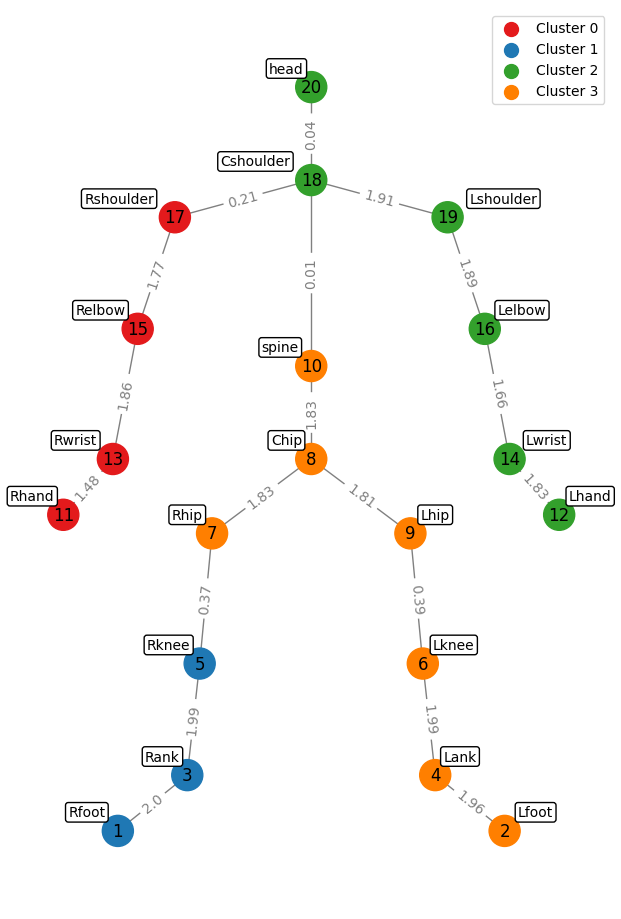

In [49]:
import networkx as nx
%matplotlib inline

jointsFrom = [1, 3, 5, 7, 2, 4, 6, 9, 8,10,11,13,15,17,12,14,16,19,18]
jointsTo =   [3, 5, 7, 8, 4, 6, 9, 8,10,18,13,15,17,18,14,16,19,18,20]
allNodes = set(jointsFrom).union(set(jointsTo))
jointsFrom = list(map(lambda x: x-1,jointsFrom))
jointsTo = list(map(lambda x: x-1,jointsTo))
edges = np.array(list(zip(jointsFrom,jointsTo))+list(zip(jointsTo,jointsFrom)))

adjacencyMatrix = np.zeros((20,20),dtype=bool)
adjacencyMatrix[edges[:,0],edges[:,1]] = True

timeInstant = 1
featureTable = angularMomentumTable

# using norm of either velocity / acceleration / energy as feature
if '_X' in featureTable.columns[0]:
    tol = featureTable.mean(axis=None) * 10**-3
# using angular momentum vector as feature
else:
    tol = None
    
weightMatrix = calculate_weight_matrix(featureTable.iloc[timeInstant],adjacencyMatrix,tol)
predicted_labels = shi_malik_spectral_clustering_matlab_version(weightMatrix)

# Create a graph using NetworkX from the adjacency matrix
graph = nx.from_numpy_array(np.multiply(adjacencyMatrix,weightMatrix))
graph = nx.relabel_nodes(graph, {node: list(allNodes)[i] for i,node in enumerate(graph.nodes())})

# Get edge labels from adjacency matrix (if present)
edge_labels = nx.get_edge_attributes(graph, "weight")
# Clip edge weights to the 2nd decimal place
for edge, weight in edge_labels.items():
    edge_labels[edge] = round(weight, 2)

# You can also create an undirected graph by using create_using=nx.Graph

pos = map_pos_human_body_graph()
# Create the colormap
# Define a pool of colors for k classes (you can add more colors if needed)
color_pool = ['#e31a1c', '#1f78b4', '#33a02c', '#ff7f00', '#6a3d9a', '#b15928']

# Use the color pool to map cluster labels to colors
node_colors = [color_pool[label % len(color_pool)] for label in predicted_labels]

fig = plt.figure(figsize=(6,9))
#canvas = fig.canvas
nx.draw(graph, pos, with_labels=True, node_size=500, node_color=node_colors, edge_color="gray")
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=10, font_color='gray', label_pos=0.5)

# Create a custom legend for cluster labels
unique_labels = np.unique(predicted_labels)

# Create a custom legend for cluster labels using the color pool
legend_labels = {label: f"Cluster {label}" for label in unique_labels}
plt.legend(handles=[plt.scatter([], [], s=100, c=color, marker='o', label=legend_labels[label]) for label, color in zip(unique_labels, color_pool)], loc="upper right")


# Add annotations for joint names
#TODO joints are inverted originally
for node, (x, y) in pos.items():
    plt.text(-x-(np.sign(x) or True)*len(indxToPhys[node])*0.025, y+0.05, indxToPhys[node], fontsize=10, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))

#canvas.draw()
#image_flat = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
#image = image_flat.reshape(*reversed(canvas.get_width_height()), 3)
#from PIL import Image
#Image.fromarray(image).save("clustering1.png")

plt.show()

#### Plotting skeleton with a slider to see default clusters evolution along times

In [50]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets

%matplotlib inline
featuresTable = angularMomentumTable
jointsFrom = [1, 3, 5, 7, 2, 4, 6, 9, 8,10,11,13,15,17,12,14,16,19,18]
jointsTo =   [3, 5, 7, 8, 4, 6, 9, 8,10,18,13,15,17,18,14,16,19,18,20]
allNodes = set(jointsFrom).union(set(jointsTo))
jointsFrom = list(map(lambda x: x-1,jointsFrom))
jointsTo = list(map(lambda x: x-1,jointsTo))
edges = np.array(list(zip(jointsFrom,jointsTo))+list(zip(jointsTo,jointsFrom)))

adjacencyMatrix = np.zeros((20,20),dtype=bool)
adjacencyMatrix[edges[:,0],edges[:,1]] = True


def update_graph(timeInstant):
    weightMatrix = calculate_weight_matrix(featureTable.iloc[timeInstant],adjacencyMatrix)
    predicted_labels = shi_malik_spectral_clustering_matlab_version(weightMatrix)
    
    graph = nx.from_numpy_array(np.multiply(adjacencyMatrix,weightMatrix))
    graph = nx.relabel_nodes(graph, {node: list(allNodes)[i] for i, node in enumerate(graph.nodes())})

    edge_labels = nx.get_edge_attributes(graph, "weight")
    for edge, weight in edge_labels.items():
        edge_labels[edge] = round(weight, 2)

    pos = map_pos_human_body_graph()

    node_colors = [color_pool[label % len(color_pool)] for label in predicted_labels]

    plt.figure(figsize=(6, 9))
    nx.draw(graph, pos, with_labels=True, node_size=500, node_color=node_colors, edge_color="gray")
    nx.draw_networkx_edge_labels(graph, pos,edge_labels=edge_labels, font_size=10, font_color='gray', label_pos=0.5)
    plt.title(f"Time Instant: {timeInstant}")

    plt.show()


time_slider = widgets.IntSlider(min=0, max=(len(featuresTable) - 1), step=1, value=0, description='Time Instant:')
widgets.interact(update_graph, timeInstant=time_slider)

interactive(children=(IntSlider(value=0, description='Time Instant:', max=336), Output()), _dom_classes=('widg…

<function __main__.update_graph(timeInstant)>

### Computing Minimum cost bipartite matching

TODO visualization of Hungarian Alg for thesis

In [51]:
from pandas import Series
from numpy import array, sum
from itertools import permutations
from typing import Literal
from networkx.algorithms.bipartite import minimum_weight_full_matching as min_wei_ful_match

def compute_cost(fromLabels:list,toLabels:list,labels_kind:Literal['full','cluster']='full'):
    if labels_kind == 'full':
        assert len(fromLabels) == len(toLabels)
        return sum(array(fromLabels) != array(toLabels))
    elif labels_kind =='cluster':
        return len(set(toLabels).difference(set(fromLabels)))
    raise Exception("method not implemented")

def clusterize_labels(labels:list): # assuming labels as list of integers going from 0 to n
    df = Series(labels)
    clusters = df.groupby(df).groups
    keys = set(clusters.keys())
    for i in range(max(keys)):
        if i not in keys:
            clusters[i] = []
    return clusters

numNodes = len(allNodes)

def labelize_clusters(clusters:dict):
    clusterLabels = np.zeros(numNodes, dtype=int)
    for clusterLabel, indices in clusters.items():
        clusterLabels[indices] = clusterLabel
    return clusterLabels

def compute_minimum_weight_cluster(fromLabels:list,toLabels:list,method:Literal['BF','MWPM']="BF",visualize=False,return_relabeling=False) -> tuple :
    # Reassign labels 
    out_elements =[]
    if method.upper() == "BF":
        toClusters = clusterize_labels(toLabels)
        clusterLabelPermutations = list(permutations(list(toClusters.keys())))
        toClustersValues = list(toClusters.values())
        optimalLabelingIndex = -1
        minCost = 10**5
        if visualize:
            leftNodes = [0]
            rightNodes = list(range(1,len(clusterLabelPermutations)+1))
            plt.figure(figsize=(8,8))
            G = nx.DiGraph()
            G.add_nodes_from(leftNodes,bipartite=0,color='#1f78b4')
            G.add_nodes_from(rightNodes,bipartite=1,color='#33a02c')
            pos = nx.bipartite_layout(G,leftNodes)
            x_center = pos[leftNodes[0]][0]
            y_center = pos[leftNodes[0]][1]
            for node in rightNodes:
                angle = (2 * node * 3.14159) / len(rightNodes)  # Distribute the right nodes evenly around the center node
                distance = 2.0  # Adjust this value to control the distance of the right nodes from the center node
                x = x_center + distance * np.cos(angle)
                y = y_center + distance * np.sin(angle)
                pos[node] = (x, y)
            
        for indexPermutation,clusterLabelPermutation in enumerate(clusterLabelPermutations):
            permCost = compute_cost(fromLabels,labelize_clusters(dict(zip(clusterLabelPermutation,toClustersValues))))
            if visualize:
                G.add_edge(leftNodes[0],rightNodes[indexPermutation],weight=permCost,color='b',width=1)
            if permCost < minCost:
                optimalLabelingIndex = indexPermutation
                minCost = permCost
        if visualize:
            edgeColors = ['b' if i == optimalLabelingIndex else '#C4C2C6' for i in range(len(rightNodes))]
            edgeWidths = [3 if i == optimalLabelingIndex else 1 for i in range(len(rightNodes))]
            nx.draw(G, pos=pos,with_labels=True,node_size=900,node_color=list(nx.get_node_attributes(G, 'color').values()),edge_color=edgeColors,width=edgeWidths)
            nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G,'weight'), label_pos=0.5)
        out_elements.append(labelize_clusters(dict(zip(clusterLabelPermutations[optimalLabelingIndex],toClustersValues))))
        if return_relabeling:
            out_elements.append(clusterLabelPermutations[optimalLabelingIndex])
    elif method.upper() == 'MWPM':
        fromClustersMap = clusterize_labels(fromLabels)
        clusters = list(fromClustersMap.keys())
        toClustersUnlabelized = list(clusterize_labels(toLabels).values())
        rightNodes = (np.array(clusters) + max(clusters)+1).tolist()
        color_pool = ['#e31a1c', '#1f78b4', '#33a02c', '#ff7f00', '#6a3d9a', '#b15928']

        edgeWeights = {fromLabel : 
                            {toLabelAssigned+max(clusters)+1 : 
                                {'weight': compute_cost(fromClustersMap[fromLabel],toClustersUnlabelized[toLabelAssigned],labels_kind='cluster')}
                             for toLabelAssigned in clusters } 
                         for fromLabel in clusters }
        
        G = nx.from_dict_of_dicts(edgeWeights,create_using=nx.DiGraph)
        
        minWeightsEdges = {fromNode:toNode for fromNode, toNode in min_wei_ful_match(G,clusters,'weight').items() if fromNode not in rightNodes}
        reversedWeightsEdgesDict = {value:key for key,value in minWeightsEdges.items()}
        if visualize:
            plt.figure(figsize=(11,8))
            pos = nx.bipartite_layout(G, clusters)
            nx.draw(G, 
                    pos,
                    with_labels=False,
                    node_size=1000, 
                    node_color= [color_pool[nodeId] for nodeId in clusters] +
                                [color_pool[reversedWeightsEdgesDict[toNodeId]] for toNodeId in sorted(reversedWeightsEdgesDict.keys())], 
                    font_size=10,
                    edge_color=[color_pool[edge[0]] if edge in list(minWeightsEdges.items()) else '#C4C2C6' for edge in G.edges()],
                    width=[3 if edge in list(minWeightsEdges.items()) else 1 for edge in G.edges()])
            nx.draw_networkx_edge_labels(G, 
                                         pos, 
                                         edge_labels=nx.get_edge_attributes(G, 'weight'),
                                         label_pos=0.85,
                                         font_size=9,
                                         font_weight='bold')
            for node in G.nodes:
                text = list(fromClustersMap[node]) if node <= max(clusters) else list(toClustersUnlabelized[node-max(clusters)-1])
                text = list(map(str,text))
                text = '\n'.join(','.join(text[i:i+4]) for i in range(0, len(text), 4))
                
                plt.text(pos[node][0], 
                         pos[node][1]+0.1, 
                         text,#str(list(fromClustersMap[node]))[1:-1] if node <= max(clusters) else str(list(toClustersUnlabelized[node-max(clusters)-1]))[1:-1], 
                         ha='center', 
                         va='center', 
                         color='black', 
                         fontsize=10,
                         fontweight='bold')
            plt.suptitle('Minimum weight clusters',fontsize=14,fontweight='bold')
            plt.show()
        out_elements.append(labelize_clusters({fromNode: toClustersUnlabelized[minWeightsEdges[fromNode]-max(clusters)-1] for fromNode in minWeightsEdges.keys()}))
        if return_relabeling:
            out_elements.append({fromNode: minWeightsEdges[fromNode]-max(clusters)-1 for fromNode in minWeightsEdges.keys()})
    return out_elements if len(out_elements) > 1 else out_elements[0]



#### Visualize a sample

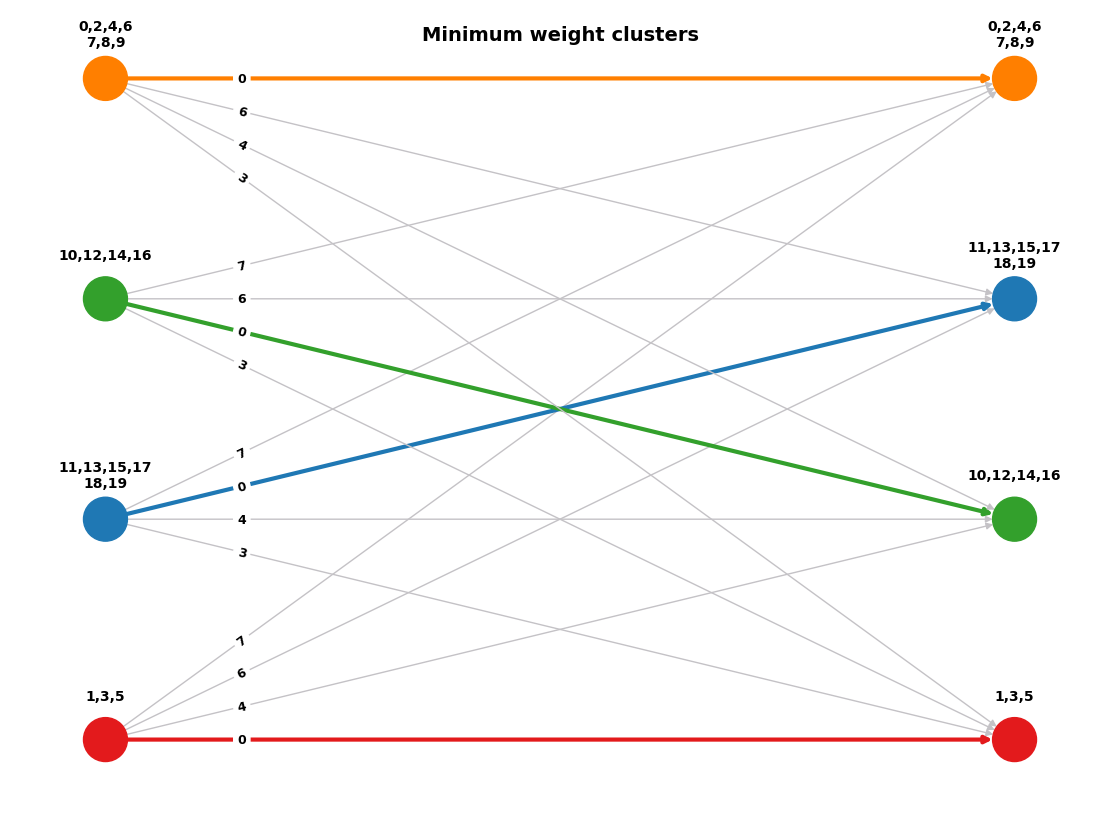

labels at t=5:		 [3 0 3 0 3 0 3 3 3 3 2 1 2 1 2 1 2 1 1 1]
labels at t=6:		 [3 0 3 0 3 0 3 3 3 3 1 2 1 2 1 2 1 2 2 2]
relabeled at t=6:	 [3 0 3 0 3 0 3 3 3 3 2 1 2 1 2 1 2 1 1 1]
optimal swap:		 0 -> 0	 1 -> 2	 2 -> 1	 3 -> 3


In [52]:
times = [5,6]
predicted_labels0 = shi_malik_spectral_clustering_matlab_version(calculate_weight_matrix(angularMomentumTable.iloc[times[0]],adjacencyMatrix))    
predicted_labels1 = shi_malik_spectral_clustering_matlab_version(calculate_weight_matrix(angularMomentumTable.iloc[times[1]],adjacencyMatrix))

totalLabels = list(clusterize_labels(predicted_labels0).keys())
clusterize_labels(predicted_labels1)

optimalLabels,relabelings = compute_minimum_weight_cluster(predicted_labels0,predicted_labels1,method='MWPM',visualize=True,return_relabeling=True)
#optimalLabels = compute_minimum_weight_cluster(predicted_labels0,predicted_labels1,method='MWPM',visualize=True,return_relabeling=False)
print(f"labels at t={times[0]}:\t\t",predicted_labels0)
print(f"labels at t={times[1]}:\t\t",predicted_labels1)
print(f'relabeled at t={times[1]}:\t',optimalLabels)
print('optimal swap:\t\t',str(relabelings).replace(':',' ->').replace(',','\t')[1:-1])

#### OPTIONAL VISUALIZATION showing by labels

/home/gagg/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


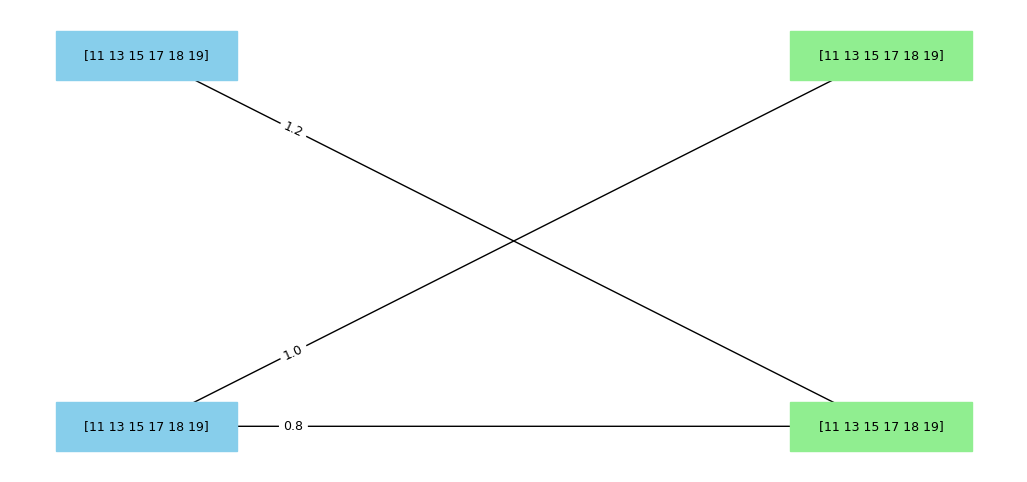

In [53]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a dictionary of edges with weights like this (node1 -> {node3: {'weight': 1.2}}):
edges_dict_with_weights = {
    'node1': {'node3': {'weight': 1.2}},
    'node2': {'node3': {'weight': 0.8}, 'node4': {'weight': 1.0}}
}

# Create the graph directly from the dictionary of edges with weights
G = nx.from_dict_of_dicts(edges_dict_with_weights,create_using=nx.DiGraph)

# Create bipartite layout
left_nodes = ['node1', 'node2']
right_nodes = ['node3', 'node4']

example = np.array([11, 13, 15, 17,18,19])
matching = nx.algorithms.bipartite.minimum_weight_full_matching(G, left_nodes, 'weight')
pos = nx.bipartite_layout(G, left_nodes)

# Extract the weights of edges to use for edge labels (optional)
edge_labels = nx.get_edge_attributes(G, 'weight')

# Set node colors
node_colors = ['skyblue' if node in left_nodes else 'lightgreen' for node in G.nodes]

# Draw the bipartite graph using Matplotlib
plt.figure(figsize=(13, 6))

# Draw edges
nx.draw_networkx_edges(G, pos, width=1, alpha=1)  # Set alpha to 1 for non-transparent edges
nx.draw_networkx_edge_labels(G,pos,nx.get_edge_attributes(G, 'weight'),label_pos=0.8,font_size=9)
# Draw nodes as rectangular patches proportional to the label size
for node, color in zip(G.nodes, node_colors):
    x, y = pos[node]
    label_size = len(str(example)) * 0.013  # Adjust this factor as needed
    width = label_size
    height = 0.1
    plt.fill([x - width, x + width, x + width, x - width], [y - height, y - height, y + height, y + height], color=color)
    plt.text(x, y, example, ha='center', va='center', color='black', fontsize=9)

# Add edge labels
for (u, v), label in edge_labels.items():
    x = (pos[u][0] + pos[v][0]) / 2 - 0.4
    y = (pos[u][1] + pos[v][1]) / 2
    #plt.text(x, y, str(label), ha='center', va='center', fontweight='bold', fontsize=9)

plt.axis('off')
plt.show()


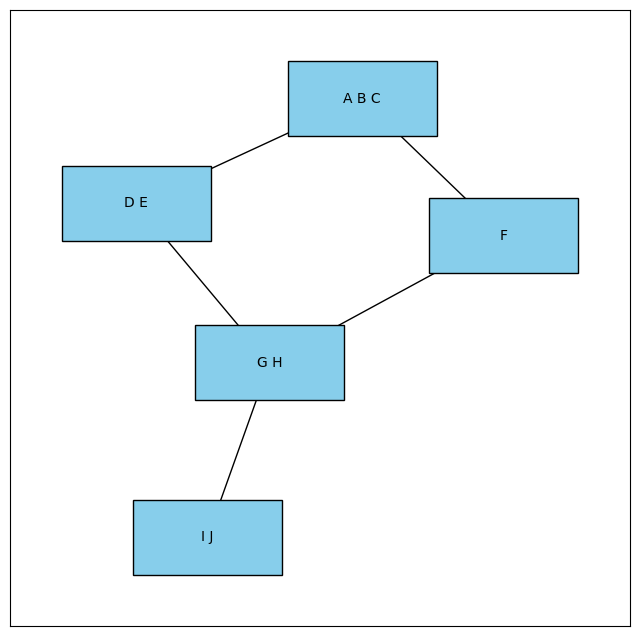

In [54]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
nodes = [1, 2, 3, 4, 5]
G.add_nodes_from(nodes)

# Add edges to the graph
edges = [(1, 2), (1, 3), (2, 4), (3, 4), (4, 5)]
G.add_edges_from(edges)

# Define labels for nodes
node_labels = {
    1: ['A', 'B', 'C'],
    2: ['D', 'E'],
    3: ['F'],
    4: ['G', 'H'],
    5: ['I', 'J']
}

# Create the figure and axis for the plot
fig, ax = plt.subplots(figsize=(8,8))

# Draw the graph with square nodes
pos = nx.spring_layout(G)  # Positions for nodes

# Draw edges
nx.draw_networkx_edges(G, pos, ax=ax)

# Draw nodes as squares
node_size = 0.3
node_color = 'skyblue'
for node, label_list in node_labels.items():
    x, y = pos[node]
    ax.add_patch(plt.Rectangle((x - node_size/2, y - node_size/2), node_size, node_size, facecolor=node_color, edgecolor='black'))
    label_text = ' '.join(label_list)
    ax.text(x, y, label_text, ha='center', va='center', color='black')

# Adjust plot limits to include all nodes
ax.autoscale()
ax.margins(0.1)

# Hide axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Show the plot
plt.show()


### Showing clustering results for the whole timeframe

2D mockup videos frame

In [55]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output, display

%matplotlib inline
featuresTable = angularMomentumTable
jointsFrom = [1, 3, 5, 7, 2, 4, 6, 9, 8,10,11,13,15,17,12,14,16,19,18]
jointsTo =   [3, 5, 7, 8, 4, 6, 9, 8,10,18,13,15,17,18,14,16,19,18,20]
allNodes = set(jointsFrom).union(set(jointsTo))
jointsFrom = list(map(lambda x: x-1,jointsFrom))
jointsTo = list(map(lambda x: x-1,jointsTo))
edges = np.array(list(zip(jointsFrom,jointsTo))+list(zip(jointsTo,jointsFrom)))

adjacencyMatrix = np.zeros((20,20),dtype=bool)
adjacencyMatrix[edges[:,0],edges[:,1]] = True

def update_graph(timeInstant,prevLabels=None,draw=True):
    weightMatrix = calculate_weight_matrix(featureTable.iloc[timeInstant],adjacencyMatrix)
    predicted_labels = shi_malik_spectral_clustering_matlab_version(weightMatrix)
    if prevLabels is not None:
        predicted_labels = compute_minimum_weight_cluster(prevLabels,predicted_labels)
    
    if draw:
        graph = nx.from_numpy_array(np.multiply(adjacencyMatrix,weightMatrix))
        graph = nx.relabel_nodes(graph, {node: list(allNodes)[i] for i, node in enumerate(graph.nodes())})

        edge_labels = nx.get_edge_attributes(graph, "weight")
        for edge, weight in edge_labels.items():
            edge_labels[edge] = round(weight, 2)

        pos = map_pos_human_body_graph()

        node_colors = [color_pool[label % len(color_pool)] for label in predicted_labels]

        clear_output(wait=True)  # This clears the previous plot
        fig = plt.figure(figsize=(6, 9))
        nx.draw(graph, pos, with_labels=True, node_size=500, node_color=node_colors, edge_color="gray")
        nx.draw_networkx_edge_labels(graph, pos,edge_labels=edge_labels, font_size=10, font_color='gray', label_pos=0.5)
        plt.title(f"Time Instant: {timeInstant}")
        display(fig)  # This displays the updated plot
        plt.close(fig)
    return predicted_labels

currLabels = None
for timeInstant in range(-len(featuresTable)):  # WARNING SET TO -len() to prevent rerunning each time
    currLabels = update_graph(timeInstant,currLabels)
    time.sleep(0.1)

jointLabels = np.zeros((len(featuresTable)+1,20),dtype=int)
for timeInstant in range(len(featuresTable)):
    jointLabels[timeInstant+1,:] = update_graph(timeInstant, jointLabels[timeInstant] if timeInstant > 0 else None,draw=False)
jointLabels = jointLabels[1:,:]

/tmp/ipykernel_3062/1140295680.py:89: ComplexWarning: Casting complex values to real discards the imaginary part
  shi_lambda[isplit] = lambda1
/tmp/ipykernel_3062/1140295680.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  shi_ww[isplit,:nn1] = ww1


In [56]:
from matplotlib import pyplot as plt
%matplotlib
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


plt.close("all")
fig = plt.figure()
ax:plt.Axes = fig.add_subplot(111, projection='3d')


minMax = np.zeros((2,3))
minMax[0,:] = [posTableX.values.min(),posTableY.values.min(),posTableZ.values.min()]
minMax[1,:] = [posTableX.values.max(),posTableY.values.max(),posTableZ.values.max()]

# Set appropriate axis limits
ax.set_xlim([minMax[0,0],minMax[1,0]])
ax.set_ylim([minMax[0,1],minMax[1,1]])
ax.set_zlim([minMax[0,2],minMax[1,2]])

# Set the window title
fig.canvas.manager.window.title("3D Movement with clusters\t(Scroll with mouse wheel)")

# Set the initial time index
time_index = 0
jointColors = np.vectorize(lambda joint: color_pool[joint])(jointLabels)

# Function to update the plot based on the slider value
def update_plot(val):
    ax.cla()  # Clear the previous plot
    
    # Filter the data based on the current time index
    filteredX = posTableX.iloc[val]
    filteredY = posTableY.iloc[val]
    filteredZ = posTableZ.iloc[val]
    
    ax.scatter(filteredX,filteredY,filteredZ,c=jointColors[val,:])

    ax.set_xlim([minMax[0,0],minMax[1,0]])
    ax.set_ylim([minMax[0,1],minMax[1,1]])
    ax.set_zlim([minMax[0,2],minMax[1,2]])
    
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)
    ax.set_title("Movement "+str(picked))

    fig.canvas.draw_idle()

# Create a slider widget
slider_ax = plt.axes([0.2, 0.03, 0.6, 0.03])
maxValue = posTable.shape[0]-1
slider = Slider(slider_ax, 'TimeIndex:', 0, maxValue, valinit=time_index, valstep=1)


# Define a function to update the slider value with the mouse wheel
def on_scroll(event):
    if event.button == 'down':
        if slider.val + slider.valstep*2 <= maxValue:
            slider.set_val(slider.val + slider.valstep*2)
    elif event.button == 'up':
        if slider.val - slider.valstep*2 >= 0:
            slider.set_val(slider.val - slider.valstep*2)
        

# Connect the mouse wheel event to the function
fig.canvas.mpl_connect('scroll_event', on_scroll)


# Register the update_plot function with the slider widget
slider.on_changed(update_plot)

# Initial plot
update_plot(time_index)

# Show the plot
plt.show()


Using matplotlib backend: TkAgg


#### OPTIONAL VISUALIZATION place pictures on nodes 

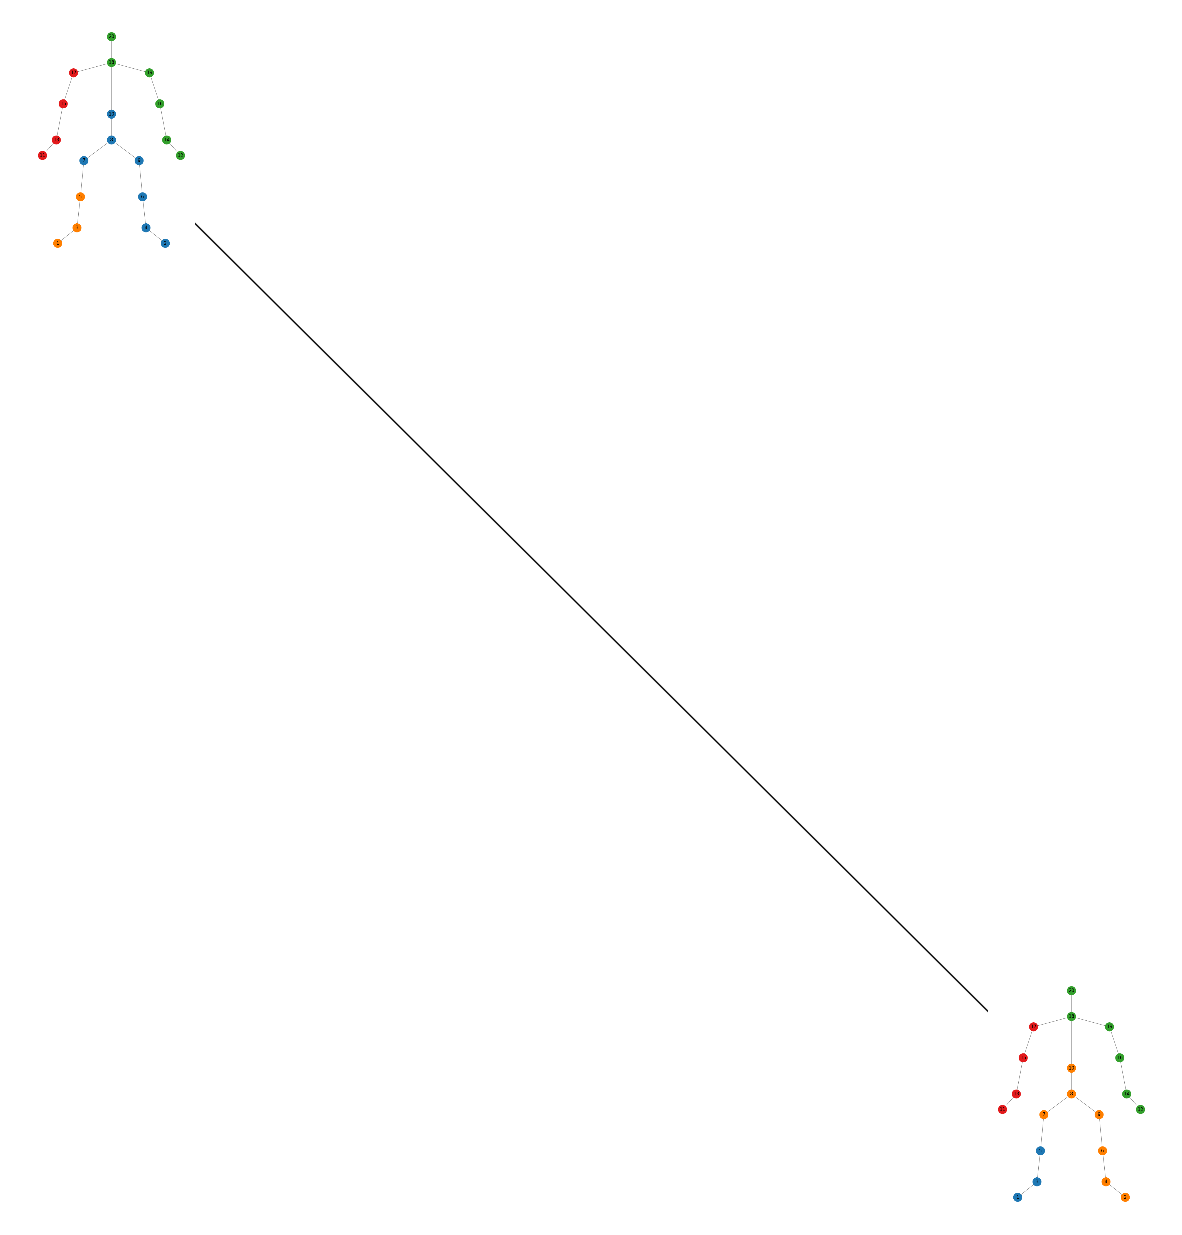

In [19]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import networkx as nx

G = nx.Graph()
G.add_node(1, label="/home/gagg/Desktop/Thesis/OoM-Thesis/code/resources/clustering.png")
G.add_node(2, label="/home/gagg/Desktop/Thesis/OoM-Thesis/code/resources/clustering1.png")
G.add_edge(1, 2)


def draw_graph_with_images(G):
    pos = nx.spring_layout(G)  # Compute node positions

    fig, ax = plt.subplots(figsize=(15,15))
    for node, data in G.nodes(data=True):
        image_path = data.get('label')
        img = plt.imread(image_path)
        imagebox = OffsetImage(img, zoom=0.2)  # Adjust zoom level as needed
        ab = AnnotationBbox(imagebox, pos[node], frameon=False)
        ax.add_artist(ab)

    nx.draw(G, pos, with_labels=False, node_size=0)  # Draw the graph without default node labels
    plt.show()

draw_graph_with_images(G)


### Calculating Auxiliary graph
| Function                             | Input                                  | Output             | Explanation                                                                                                                      |
|--------------------------------------|----------------------------------------|--------------------|----------------------------------------------------------------------------------------------------------------------------------|
| `compute_auxiliary_graph_scalar_feature` | featureVector (pd.DataFrame), clusters (np.ndarray), adjacencyMatrix (np.ndarray) | auxiliary_graph (np.ndarray) | Computes the auxiliary graph for scalar features based on the provided feature vector, clusters, and adjacency matrix. The *featureVector* is assumed to be a 1 time instant by 20 joints. The clusters a 1-D array that contains the clustering results for each joint. The adjacencyMatrix is a square matrix that represents connections between joints. The function calculates the norm of differences (in our case just modulus since features are scalar) between feature vectors for each pair of joints. Then, it sets the values in the auxiliary graph based on the adjacency matrix and cluster condition. If there is a connection between two joints (*adjacencyMatrix[i, j] = 1*) and the joints belong to different clusters (*clusters[i] != clusters[j]*), the corresponding element in the auxiliary graph is set to the absolute difference between their feature vectors otherwise to 0. *auxiliary_graph* has same dimensions as *adjacency_matrix*. For angular momentum uses the norm of the differences. |


In [22]:
import numpy as np
import pandas as pd
def compute_auxiliary_graph(featureTable:pd.DataFrame,clusters:np.ndarray,adjacencyMatrix:np.ndarray) -> np.ndarray:
    auxiliary_graph = np.zeros(adjacencyMatrix.shape)
    if isinstance(featureTable.iloc[0],np.ndarray):
        vectorsArray = np.stack(featureTable.values)
        normMatrix = np.linalg.norm(vectorsArray[:,None] - vectorsArray, axis=2)
    else:
        normMatrix = np.abs(featureTable.values[:,None] - featureTable.values)
    mask = np.logical_and(adjacencyMatrix,clusters[:,None] != clusters)
    auxiliary_graph[mask] = normMatrix[mask]
    return auxiliary_graph

In [10]:
import networkx as nx
%matplotlib inline

jointsFrom = [1, 3, 5, 7, 2, 4, 6, 9, 8,10,11,13,15,17,12,14,16,19,18]
jointsTo =   [3, 5, 7, 8, 4, 6, 9, 8,10,18,13,15,17,18,14,16,19,18,20]
allNodes = set(jointsFrom).union(set(jointsTo))
jointsFrom = list(map(lambda x: x-1,jointsFrom))
jointsTo = list(map(lambda x: x-1,jointsTo))
edges = np.array(list(zip(jointsFrom,jointsTo))+list(zip(jointsTo,jointsFrom)))

adjacencyMatrix = np.zeros((20,20),dtype=bool)
adjacencyMatrix[edges[:,0],edges[:,1]] = True

timeInstant = 1
featureTable = angularMomentumTable

# using norm of either velocity / acceleration / energy as feature
if '_X' in featureTable.columns[0]:
    tol = featureTable.mean(axis=None) * 10**-3 
# using angular momentum vector as feature
else:
    tol = None

predicted_labels = shi_malik_spectral_clustering_matlab_version(calculate_weight_matrix(featureTable.iloc[timeInstant],adjacencyMatrix,tol))
weightMatrix = compute_auxiliary_graph(featuresTable.iloc[0],predicted_labels,adjacencyMatrix)

# Create a graph using NetworkX from the adjacency matrix
graph = nx.from_numpy_array(np.multiply(adjacencyMatrix,weightMatrix))
graph = nx.relabel_nodes(graph, {node: list(allNodes)[i] for i,node in enumerate(graph.nodes())})

# Get edge labels from adjacency matrix (if present)
edge_labels = nx.get_edge_attributes(graph, "weight")
# Clip edge weights to the 2nd decimal place
for edge, weight in edge_labels.items():
    edge_labels[edge] = round(weight, 2)

# You can also create an undirected graph by using create_using=nx.Graph

pos = map_pos_human_body_graph()
# Create the colormap
# Define a pool of colors for k classes (you can add more colors if needed)
color_pool = ['#e31a1c', '#1f78b4', '#33a02c', '#ff7f00', '#6a3d9a', '#b15928']

# Use the color pool to map cluster labels to colors
node_colors = [color_pool[label % len(color_pool)] for label in predicted_labels]

fig = plt.figure(figsize=(6,9))
#canvas = fig.canvas
nx.draw(graph, pos, with_labels=True, node_size=500, node_color=node_colors, edge_color="gray")
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=10, font_color='gray', label_pos=0.5)

# Create a custom legend for cluster labels
unique_labels = np.unique(predicted_labels)

# Create a custom legend for cluster labels using the color pool
legend_labels = {label: f"Cluster {label}" for label in unique_labels}
plt.legend(handles=[plt.scatter([], [], s=100, c=color, marker='o', label=legend_labels[label]) for label, color in zip(unique_labels, color_pool)], loc="upper right")


# Add annotations for joint names
#TODO joints are inverted originally
for node, (x, y) in pos.items():
    plt.text(-x-(np.sign(x) or True)*len(indxToPhys[node])*0.025, y+0.05, indxToPhys[node], fontsize=10, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
plt.title("Auxiliary Graph")
#canvas.draw()
#image_flat = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
#image = image_flat.reshape(*reversed(canvas.get_width_height()), 3)
#from PIL import Image
#Image.fromarray(image).save("clustering1.png")

plt.show()

NameError: name 'angularMomentumTable' is not defined

### Shapley Values

In [ ]:
import numpy as np
def calculate_shapley_values(auxiliaryGraph:np.ndarray):
    shapleys = 0.5 * np.sum(auxiliaryGraph,axis=1)
    maxShapley = np.max(shapleys)
    utilityNormFactor = np.sum(shapleys)
    return shapleys, shapleys / maxShapley, shapleys / utilityNormFactor # should also return mean across every time instant

#### DON'T remember where this come from

In [78]:
shapleys = pd.DataFrame(columns=['firstMaxValue','firstIndex','secondMaxValue','secondIndex']).astype({ 'firstMaxValue': float,
                                                                                                        'firstIndex': int,
                                                                                                        'secondMaxValue': float,
                                                                                                        'secondIndex': int
                                                                                                    })
shapleys['firstMaxValue'] = featuresTableNormalized.max(axis=1)
shapleys['firstIndex'] = [int(featuresTableNormalized.columns.get_loc(row)) for row in featuresTableNormalized.idxmax(axis=1)]

# set max values cells to -inf 
tableWithoutFirstMax = featuresTableNormalized.copy()
for i,shap_row in shapleys.iterrows():
    tableWithoutFirstMax.iloc[i, int(shap_row['firstIndex'])] = float('-inf') 

shapleys['secondMaxValue'] = tableWithoutFirstMax.max(axis=1)
shapleys['secondIndex'] = [tableWithoutFirstMax.columns.get_loc(row) for row in tableWithoutFirstMax.idxmax(axis=1)]

print(shapleys)

     firstMaxValue  firstIndex  secondMaxValue  secondIndex
0              2.0          13        1.996316            1
1              2.0           1        1.997122           13
2              2.0          13        1.981765           17
3              2.0          13        1.988791           17
4              2.0          13        1.999259            9
..             ...         ...             ...          ...
572            2.0          17        1.997838           13
573            2.0          17        1.996498           13
574            2.0          17        1.995206           13
575            2.0          17        1.994868           13
576            2.0          17        1.994858           13

[577 rows x 4 columns]


## DEPRECATED Calculating features based on version: Olga Python notebooks

### Calculating features

In [13]:
m_lfoot = 0.0145;m_rfoot = 0.0145;m_lank = 0.0465;m_rank = 0.0465
m_lknee = 0.1;m_rknee = 0.1;m_lhip = 0.1;m_hipc = 0.139;m_rhip = 0.1
m_spine = 0.216;m_lhand = 0.006;m_rhand = 0.006;m_lwrist = 0.016;m_rwrist = 0.016
m_lelb = 0.028;m_relb = 0.028;m_lsho = 0.0158;m_shoc = 0.081;m_rsho = 0.0158;m_head = 0.081

mass = [m_lfoot,
        m_rfoot, 
        m_lank,
        m_rank,
        m_lknee, 
        m_rknee, 
        m_lhip,
        m_hipc,
        m_rhip,
        m_spine,
        m_lhand,
        m_rhand,
        m_lwrist,
        m_rwrist,
        m_lelb,
        m_relb,
        m_lsho,
        m_shoc,
        m_rsho,
        m_head  ]

In [14]:
def xyz_tables_to_xyz_columns(xTable,yTable,zTable):
    mergedTable = pd.DataFrame()
    for j in range(xTable.shape[1]):
        mergedTable = pd.concat([mergedTable,xTable.iloc[:,j],yTable.iloc[:,j],zTable.iloc[:,j]],axis=1)
    return mergedTable

def table_to_list_xyz_tables(table,into="xyz"):
    if into == "xyz":
        return table.iloc[:,::3],table.iloc[:,1::3],table.iloc[:,2::3]
    elif into == "points":
        return [table.iloc[:,j:j+3] for j in range(0,table.shape[1],3)]

In [15]:
centerOfMassX = posTableX.dot(mass).div(sum(mass))
centerOfMassY = posTableY.dot(mass).div(sum(mass))
centerOfMassZ = posTableZ.dot(mass).div(sum(mass))

radiusQX = posTableX.sub(centerOfMassX,axis=0)
radiusQY = posTableY.sub(centerOfMassY,axis=0)
radiusQZ = posTableZ.sub(centerOfMassZ,axis=0)

radiusQTable = xyz_tables_to_xyz_columns(radiusQX,radiusQY,radiusQZ)
timeCol = table[table["Time"].between(startEndSeconds[0],startEndSeconds[1])]["Time"]
velocityTable = pd.DataFrame(np.gradient(posTable,timeCol,axis=0),columns=[f'{c}' for c in posTable.columns])
p = velocityTable.mul(np.repeat(mass,3))
p = [point.to_numpy() for point in table_to_list_xyz_tables(p,into="points")]
r = [point.to_numpy() for point in table_to_list_xyz_tables(radiusQTable, into="points")]
l = np.cross(p,r)

angularMomentumTable = radiusQTable*0
for j,point in enumerate(l):
    for i in range(len(point)):
        angularMomentumTable.iloc[i,3*j:3*j+3] = point[i]
angularMomentumTable.head()

,left_foot_X,left_foot_Y,left_foot_Z,right_foot_X,right_foot_Y,right_foot_Z,left_ankle_X,left_ankle_Y,left_ankle_Z,right_ankle_X,...,left_shoulder_Z,shoulder_center_X,shoulder_center_Y,shoulder_center_Z,right_shoulder_X,right_shoulder_Y,right_shoulder_Z,head_X,head_Y,head_Z
3552,-8.481859e-08,-0.000002,1.288280e-07,-4.990366e-07,1.018480e-06,1.268165e-08,0.000009,-0.000054,7.135355e-07,0.000198,...,-0.000021,0.000260,0.000691,0.000044,0.000055,0.000279,0.000037,-0.000133,0.000106,0.000003
3553,-8.928879e-08,-0.000002,1.039464e-07,-6.971826e-07,9.501523e-07,4.568127e-08,0.000010,-0.000055,8.275951e-07,0.000209,...,-0.000021,0.000259,0.000704,0.000045,0.000055,0.000284,0.000037,-0.000129,0.000092,0.000002
3554,-1.782143e-07,-0.000001,5.943020e-08,-1.020653e-06,6.242300e-07,1.120537e-07,0.000011,-0.000057,9.706263e-07,0.000227,...,-0.000020,0.000258,0.000728,0.000047,0.000056,0.000294,0.000038,-0.000121,0.000069,0.000002
3555,-3.601246e-07,-0.000001,3.328653e-08,-1.111757e-06,1.507145e-08,1.611017e-07,0.000012,-0.000060,1.016623e-06,0.000237,...,-0.000021,0.000262,0.000748,0.000049,0.000057,0.000302,0.000039,-0.000110,0.000051,0.000002
3556,-4.814908e-07,-0.000001,3.863321e-08,-8.563568e-07,-6.881588e-07,1.650597e-07,0.000012,-0.000062,1.084644e-06,0.000238,...,-0.000021,0.000274,0.000770,0.000050,0.000060,0.000312,0.000041,-0.000099,0.000037,0.000002


### Grouping features by joint
![bodymarkersCosine](../resources/bodymarkersForCosine.png)

In [16]:
def group_table_by_joints(table):
    columns = [col.replace('_X','') for col in list(table.columns)[::3]]
    result = pd.DataFrame(columns=columns)
    for j in range(0,table.shape[1],3):
        lst = []
        for i in range(table.shape[0]):
            lst.append(table.iloc[i,j:j+3].values)
        result[columns[int(j/3)]] = lst
    return result

In [19]:
velocityGroupedTable = group_table_by_joints(velocityTable)
velocityGroupedTable.head()

,left_foot,right_foot,left_ankle,right_ankle,left_knee,right_knee,left_hip,hip_center,right_hip,spine,left_hand,right_hand,left_wrist,right_wrist,left_elbow,right_elbow,left_shoulder,shoulder_center,right_shoulder,head
0,"[-0.0001254673411550688, -9.268622245729396e-0...","[6.84105681252281e-05, 3.46442371976738e-05, -...","[-0.001415555515084548, -0.0002517353097207952...","[-0.001175580589655499, -0.00576144123575621, ...","[-0.003481523025714679, -0.0007169704127632261...","[-0.004022795775048698, 0.000522172573803472, ...","[0.00021713718906718948, 0.0009298940790016282...","[-0.004742270795854533, 0.002927280175145374, ...","[-0.009682346128310801, 0.004924181231769374, ...","[-0.00933841719863727, 0.0015740534990371904, ...","[0.04385639409691921, -0.006443926431863135, 0...","[-0.08549249293415308, 0.012489523030522483, 0...","[0.00914439784778536, 0.017839138330687995, 0....","[-0.08874700360236328, 0.0037445019023082254, ...","[0.014755502639079387, -0.0015652610069668811,...","[-0.07276486564594041, 0.0038302793778231302, ...","[0.0015619588159340027, 0.006586192417440808, ...","[-0.01929443815853983, 0.007085321428030804, 0...","[-0.0401508351330989, 0.00758445043859949, 0.0...","[-0.001974528944453083, -0.0023699309261042837..."
1,"[-0.00010205854146505544, -7.086194935168599e-...","[6.776359730054082e-05, 5.24716858273655e-05, ...","[-0.0014542860621347131, -0.000274234355813529...","[-0.0010374899895566614, -0.006095150137306327...","[-0.003448202613810736, -0.0006778224689867329...","[-0.004477005260852707, 0.0008798458540582033,...","[0.0025030070027796114, 0.0009875226915738722,...","[-0.0037442508778511296, 0.0029589196123396277...","[-0.009969403270858379, 0.004929603397364701, ...","[-0.009045399332443083, 0.0018152911511180037,...","[0.04283553226022008, -0.00631915201734401, 0....","[-0.08849644544302038, 0.012134699761539025, 0...","[0.008859345979558952, 0.01792952482280441, 0....","[-0.09302340747155569, 0.0035310768949585736, ...","[0.014825990458810168, -0.0017929119206741007,...","[-0.07585054235168087, 0.0036325608333456216, ...","[0.0016841844412596174, 0.006499820255179145, ...","[-0.01965973295786938, 0.007039654817383223, 0...","[-0.04100365035699838, 0.00757948937957309, 0....","[-0.001726514068934648, -0.0023056618480694624..."
2,"[-7.086082845120245e-05, 3.0676120271189156e-0...","[5.330063294195497e-05, 8.307716000480192e-05,...","[-0.00153889175464883, -0.00030584480363904376...","[-1.1906613863743587e-06, -0.00661455372667774...","[-0.0032835230083279043, -0.000558547064891001...","[-0.0048850765667651785, 0.0013965310601307124...","[0.006648788993175003, 0.000988278674810772, -...","[-0.0020410748462964534, 0.0029839050396276434...","[-0.010705232182736779, 0.004978429525621664, ...","[-0.00830286673929237, 0.002330525054752286, -...","[0.04072392292662386, -0.006035474576862043, 0...","[-0.09401384333057194, 0.011431187661830933, 0...","[0.008268595794568512, 0.01811300512583358, 0....","[-0.10182691876205041, 0.003081106806938294, 0...","[0.014919066710362472, -0.002251903388149401, ...","[-0.08276094849174598, 0.003161977276313621, -...","[0.0019093844748709898, 0.006376678656302204, ...","[-0.02031374206642056, 0.00699001470692906, 0....","[-0.04253686860767658, 0.007603350758017768, 0...","[-0.0012951708841910659, -0.002152432346960609..."
3,"[-7.102202931008605e-05, 1.960450614685305e-05...","[1.882883828585591e-05, 9.6134086962546e-05, 0...","[-0.001630511165359394, -0.0003229474321977399...","[0.0026681374723622753, -0.006932405927479124,...","[-0.0028792167603697294, -0.000364669967030550...","[-0.00442636833306409, 0.0014807688587801238, ...","[0.009050218653982256, 0.0007973468718205368, ...","[-0.0013324456906502746, 0.0029701325226980657...","[-0.011691637722982762, 0.005141675360270881, ...","[-0.0073922215628527965, 0.0028952548440486225...","[0.03858727453598476, -0.0056890445074380125, ...","[-0.09952682827265846, 0.011133785111944405, 0...","[0.007662544163345331, 0.018

In [ ]:
accelerationGroupedTable = group_table_by_joints(accelerationTable)
accelerationGroupedTable.head()

In [17]:
angularMomentumGroupedTable = group_table_by_joints(angularMomentumTable)
angularMomentumGroupedTable.head()

,left_foot,right_foot,left_ankle,right_ankle,left_knee,right_knee,left_hip,hip_center,right_hip,spine,left_hand,right_hand,left_wrist,right_wrist,left_elbow,right_elbow,left_shoulder,shoulder_center,right_shoulder,head
0,"[-8.481858671770431e-08, -1.910949224495498e-0...","[-4.990365756585407e-07, 1.018480369309418e-06...","[9.386049570138977e-06, -5.359602458867138e-05...","[0.00019810388924009544, -9.088540060542302e-0...","[3.217748379026128e-05, -0.0001587249282897077...","[-2.353230406906948e-05, -0.000169639394177491...","[-2.8774691369438332e-05, -9.855942763861555e-...","[2.826475093963874e-05, 5.5032585571385486e-05...","[5.5342555588210434e-05, 9.62633682237234e-06,...","[0.00015078558222081986, 0.0005031829833269711...","[9.68626964197699e-06, 7.600264667906586e-05, ...","[-1.787719635740477e-05, -0.000129668977792091...","[6.321645595283168e-06, 0.00011281142627325937...","[6.153062411042985e-07, -0.0001838650685236392...","[6.155135787992385e-07, -0.0002730567565029008...","[1.783651800905553e-05, 0.0003147950444154029,...","[4.630728504330599e-05, -2.988330514329956e-06...","[0.0002598222045839961, 0.0006908105508023496,...","[5.519126385887507e-05, 0.00027861228965409023...","[-0.00013284616701182917, 0.000105813964511418..."
1,"[-8.928878908410463e-08, -1.5804297414048952e-...","[-6.971825953142204e-07, 9.501522663083293e-07...","[1.016367179739023e-05, -5.454645212163889e-05...","[0.00020942397802558956, -8.93544102681796e-05...","[3.075332328919849e-05, -0.0001543840595577321...","[-3.964136225588645e-05, -0.000183634058601283...","[-3.4780405018151594e-05, -0.00013385546205527...","[2.560609720172637e-05, 4.402216598306766e-05,...","[5.572611890082674e-05, 1.0324042639569059e-05...","[0.00016437405924825226, 0.0004870718747920191...","[9.265445649555465e-06, 7.438452470047178e-05,...","[-1.6805270008873488e-05, -0.00013643058817148...","[6.618602833056094e-06, 0.0001136428448291735,...","[2.53315888696722e-06, -0.00019786035657458752...","[2.507092198207407e-07, -0.0002733265426462690...","[1.6841696091995663e-05, 0.0003235645698483272...","[4.5818749695650985e-05, -3.324931835249495e-0...","[0.0002588409233950583, 0.0007041015195700927,...","[5.529698899187842e-05, 0.0002838908701528798,...","[-0.00012920402776149076, 9.216925768922847e-0..."
2,"[-1.7821426138501256e-07, -1.1269168442169807e...","[-1.0206528258265662e-06, 6.242300203093699e-0...","[1.1236163787542125e-05, -5.6794769772511547e-...","[0.0002267185890661297, -5.8720704441184e-05, ...","[2.6045238476386617e-05, -0.000141285077274661...","[-6.288079818853932e-05, -0.000193705022158437...","[-4.615985902188415e-05, -0.000197069668155862...","[2.044771613598332e-05, 2.526625722946964e-05,...","[5.663306789158135e-05, 1.4098543947612375e-05...","[0.00019199582999766666, 0.0004464486577189576...","[8.623407956499367e-06, 7.086383875414393e-05,...","[-1.4536947899726228e-05, -0.00014983052067495...","[7.168575709524849e-06, 0.00011497159760302777...","[6.557977843770893e-06, -0.0002271215308131915...","[-7.419165493662344e-07, -0.000274050573408230...","[1.467283192728132e-05, 0.00034082327176491355...","[4.5164677368620047e-05, -3.928459210124352e-0...","[0.0002581340489852437, 0.0007278115766093817,...","[5.5683710731205255e-05, 0.0002935276086215660...","[-0.00012057330246149072, 6.850523608907353e-0..."
3,"[-3.601245568080253e-07, -1.0872889886051335e-...","[-1.1117565523044768e-06, 1.5071449276558696e-...","[1.1799698263465517e-05, -5.952297683446257e-0...","[0.00023661004450496758, 3.065302451265209e-05...","[1.7957786972421597e-05, -0.000117403451956937...","[-6.660601654040779e-05, -0.000173761233940585...","[-5.378367239820457e-05, -0.000232753337600582...","[1.7176138408771602e-05, 1.7589483456544675e-0...","[5.8217190866700315e-05, 2.2019930083840803e-0...","[0.00022045299802646293, 0.0003968736211340009...","[8.33823661882569e-06, 6.704726280874646e-05, ...","[-1.2570633648972387e-05, -0.00016431334823468...","[7.559871526849583e-06, 0.00

### Computing cosine dist

In [19]:
from scipy.spatial.distance import cosine
def compute_cosine_similarity_on_joints(featureTable,normalized:None or int=None):
    jointsFrom = [1, 3, 5, 7, 2, 4, 6, 9, 8,10,11,13,15,17,12,14,16,19,18]
    jointsTo =   [3, 5, 7, 8, 4, 6, 9, 8,10,18,13,15,17,18,14,16,19,18,20]

    jointsFrom = list(map(lambda x: x-1,jointsFrom))
    jointsTo = list(map(lambda x: x-1,jointsTo))

    cosineSim = pd.DataFrame()
    columnNames = list(featureTable.columns)
    for jointFrom,jointTo in zip(jointsFrom,jointsTo):
        cosineSim[columnNames[jointFrom]+" - "+columnNames[jointTo]] = featureTable.apply(lambda row: 2 - cosine(row[columnNames[jointFrom]],row[columnNames[jointTo]]),axis=1)
    return cosineSim if normalized is None else cosineSim.div(cosineSim.max(axis=1))*normalized

from numpy.linalg import norm
def compute_inverse_difference_on_joints(featureTable):
    jointsFrom = [1, 3, 5, 7, 2, 4, 6, 9, 8,10,11,13,15,17,12,14,16,19,18]
    jointsTo =   [3, 5, 7, 8, 4, 6, 9, 8,10,18,13,15,17,18,14,16,19,18,20]
    jointsFrom = list(map(lambda x: x-1,jointsFrom))
    jointsTo = list(map(lambda x: x-1,jointsTo))

    invDiffModulus = pd.DataFrame()
    eps = 10**(-9)
    columnNames = list(featureTable.columns)
    for jointFrom,jointTo in zip(jointsFrom,jointsTo):
        invDiffModulus[columnNames[jointFrom]+" - "+columnNames[jointTo]] = featureTable.apply(lambda row: norm(row[columnNames[jointFrom]]-row[columnNames[jointTo]])+eps,axis=1)
    return 1 / invDiffModulus

In [20]:
cosineSimVelocity = compute_cosine_similarity_on_joints(velocityGroupedTable)
cosineSimVelocity.head()

,left_foot - left_ankle,left_ankle - left_knee,left_knee - left_hip,left_hip - hip_center,right_foot - right_ankle,right_ankle - right_knee,right_knee - right_hip,right_hip - hip_center,hip_center - spine,spine - shoulder_center,left_hand - left_wrist,left_wrist - left_elbow,left_elbow - left_shoulder,left_shoulder - shoulder_center,right_hand - right_wrist,right_wrist - right_elbow,right_elbow - right_shoulder,right_shoulder - shoulder_center,shoulder_center - head
0,1.654604,1.987798,0.991294,1.227663,0.163113,0.893574,1.731784,1.788489,1.915780,1.859122,1.204044,0.319360,0.719423,1.155518,1.992332,1.963004,1.961113,1.984694,1.078186
1,1.583031,1.983763,0.683977,1.186815,0.179242,0.759972,1.689355,1.671464,1.904179,1.855257,1.197249,0.309664,0.700845,1.134273,1.993171,1.962009,1.962075,1.985191,1.042475
2,1.452303,1.966897,0.329393,1.357355,0.652373,0.537103,1.643214,1.336151,1.798665,1.845497,1.180790,0.290637,0.667478,1.098956,1.994718,1.961771,1.965398,1.985859,0.977917
3,1.437293,1.919992,0.146294,1.466000,1.263112,0.312739,1.651958,1.156667,1.744795,1.833097,1.158421,0.272603,0.643010,1.077005,1.995856,1.964406,1.970453,1.986031,0.929563
4,1.546680,1.787501,0.041123,1.332564,1.450986,0.180274,1.713171,1.329479,1.885627,1.815295,1.131757,0.256948,0.631675,1.069317,1.996148,1.968940,1.975162,1.985811,0.888132


In [21]:
accelerationTable = pd.DataFrame(np.gradient(velocityTable,timeCol,axis=0),columns=[f'{c}' for c in velocityTable.columns])
accelerationGroupedTable = group_table_by_joints(accelerationTable)
accelerationGroupedTable.head()

,left_foot,right_foot,left_ankle,right_ankle,left_knee,right_knee,left_hip,hip_center,right_hip,spine,left_hand,right_hand,left_wrist,right_wrist,left_elbow,right_elbow,left_shoulder,shoulder_center,right_shoulder,head
0,"[0.0022465258819583172, 0.00020944599909405748...","[-6.208933058417118e-05, 0.0017108875844228254...","[-0.0037169430950242297, -0.002159217475309696...","[0.013252456823300594, -0.03202580629078764, 0...","[0.003197736267171993, 0.0037570003624261316, ...","[-0.043590161785399165, 0.03432565069622012, -...","[0.2193733026594693, 0.005530577022286474, -0....","[0.09577926276421068, 0.003036414318065591, -0...","[-0.027548670110123206, 0.0005203613815091475,...","[0.028120716525344605, 0.023151406149782523, -...","[-0.09797138547973089, 0.011974511950008059, 0...","[-0.2882871889507017, -0.03405213713851641, 0....","[-0.02735622535761165, 0.008674327458386295, 0...","[-0.41040344234078735, -0.020482246386716092, ...","[0.0067646660010324015, -0.021847496517000447,...","[-0.2961302020863193, -0.018974908299178847, 0...","[0.011729906461187578, -0.008289075073093512, ...","[-0.03505708246923503, -0.004382592192664669, ...","[-0.08184407139147742, -0.000476109311554507, ...","[0.023801811470091506, 0.00616785777685222, 0...."
1,"[0.002621892291392557, 0.0005926017143564701, ...","[-0.0007260301309411272, 0.002325742390905447,...","[-0.0059232042061084095, -0.002598092520754812...","[0.05642116601858252, -0.04096453094722413, 0....","[0.009511581070066, 0.007609234545673384, 0.04...","[-0.041393993731731776, 0.04198327245670183, -...","[0.3088545641187991, 0.0028002888260948225, -0...","[0.12971071785997945, 0.0027181229817650476, -...","[-0.049127096296865125, 0.00260633669417365, 0...","[0.049735119537872075, 0.036329091836962105, 0...","[-0.15043302446500384, 0.019616160087744416, 0...","[-0.4092063187021342, -0.0508243231613561, 0.2...","[-0.04205933626167374, 0.01315200699781749, 0....","[-0.6281453628636804, -0.03185897843636956, 0....","[0.007853376622529273, -0.03297478733612212, -...","[-0.48006527998834114, -0.032096226690030955, ...","[0.016683854553831534, -0.010059969372516409, ...","[-0.04894774785795608, -0.004575639952198229, ...","[-0.1145793502639485, 0.0009086894913371002, 0...","[0.03262287070532577, 0.010445707877656793, 0...."
2,"[0.0014914371504065492, 0.00128106503309417, 0...","[-0.002348323092447016, 0.0020969404976661733,...","[-0.008459839184193033, -0.0023392716551547035...","[0.17782338987661644, -0.04020401807225421, 0....","[0.02730465853438216, 0.01503029367258171, 0.0...","[0.002391008613550516, 0.028868866911081918, -...","[0.3143970002748315, -0.0091210685381235, -0.1...","[0.11583107138386196, 0.0005400926123975414, -...","[-0.0826689704210678, 0.010175813736871264, 0....","[0.07935751885143211, 0.05184429510669446, 0.0...","[-0.20394794244422831, 0.030247121851875447, -...","[-0.5295435502244334, -0.048070333106600804, 0...","[-0.05745500125464614, 0.01926266994482162, 0....","[-0.8832706396671552, -0.03987952885062057, 0....","[0.0072061039300512775, -0.044072093191357783,...","[-0.7455833613109859, -0.049196751051549, 0.13...","[0.02029842034981362, -0.00562225621291812, 0....","[-0.05877049669731027, 0.0018817468304695995, ...","[-0.13783941374204556, 0.00938574987594587, 0....","[0.0361911239802314, 0.016333572539862284, 0.0..."
3,"[-0.0011953059437098388, 0.0013070075735307062...","[-0.0036813785541836897, -8.409083912373381e-0...","[-0.008282098634796578, -0.0017597768720368865...","[0.29648752035873965, -0.018349242879233563, 0...","[0.052970102827685966, 0.020900555855429624, 0...","[0.07207520071783127, -0.012670786097629165, 0...","[0.08070010669248956, -0.02359412568445763, -0...","[-0.0048911142379578915, -1.79901606088273e-05...","[-0.09119195003525116, 0.02356199386965438, -0...","[0.08304227586042107, 0.055448296319774146, 0....","[-0.19787687613375216, 0.0359792806010209, -0....","[-0.6047949031999815, 0.017959981946938264, 0....","[-0.05685534772329359, 0.024

In [22]:
cosineSimAcceleration = compute_cosine_similarity_on_joints(accelerationGroupedTable)
#cosineSimAcceleration.to_csv("_cachedCosineSimAcceleration.csv",index=False)
cosineSimAcceleration.head()

,left_foot - left_ankle,left_ankle - left_knee,left_knee - left_hip,left_hip - hip_center,right_foot - right_ankle,right_ankle - right_knee,right_knee - right_hip,right_hip - hip_center,hip_center - spine,spine - shoulder_center,left_hand - left_wrist,left_wrist - left_elbow,left_elbow - left_shoulder,left_shoulder - shoulder_center,right_hand - right_wrist,right_wrist - right_elbow,right_elbow - right_shoulder,right_shoulder - shoulder_center,shoulder_center - head
0,1.292188,1.752130,0.592601,1.999890,1.435159,0.065550,1.209478,0.007272,1.699952,0.258682,1.729182,0.423349,1.289523,0.976311,1.985206,1.955291,1.965156,1.969545,0.552916
1,1.290198,1.650894,0.703564,1.999266,1.405938,0.007398,1.252511,0.035180,1.681301,0.275314,1.712872,0.459720,1.219621,0.950427,1.975255,1.964233,1.978271,1.968995,0.619387
2,1.378847,1.377037,0.938265,1.993758,1.162029,0.571685,0.915964,0.123502,1.618664,0.328339,1.674512,0.460161,0.987166,0.858353,1.958020,1.977142,1.988565,1.971078,0.757863
3,1.734856,0.889071,1.192313,1.277277,0.908177,1.978490,0.101231,1.216782,0.697483,0.482312,1.601281,0.335218,0.480632,0.813399,1.951157,1.988839,1.960873,1.976139,0.947794
4,1.912696,0.383771,0.524954,1.979696,0.659281,1.792078,0.096709,1.669335,0.337674,0.740624,1.528517,0.182537,0.245702,1.122025,1.963698,1.995203,1.905757,1.972885,1.048808


In [18]:
cosineSimAngMom = compute_cosine_similarity_on_joints(angularMomentumGroupedTable)
cosineSimAngMom.head()

,left_foot - left_ankle,left_ankle - left_knee,left_knee - left_hip,left_hip - hip_center,right_foot - right_ankle,right_ankle - right_knee,right_knee - right_hip,right_hip - hip_center,hip_center - spine,spine - shoulder_center,left_hand - left_wrist,left_wrist - left_elbow,left_elbow - left_shoulder,left_shoulder - shoulder_center,right_hand - right_wrist,right_wrist - right_elbow,right_elbow - right_shoulder,right_shoulder - shoulder_center,shoulder_center - head
0,1.974982,1.998005,1.867363,0.050282,0.238708,1.273976,0.873173,1.614838,1.757515,1.932351,1.290687,0.138325,1.043046,1.240566,1.980999,0.088756,1.979167,1.984381,1.308084
1,1.969964,1.998430,1.872270,0.054361,0.149527,1.173610,0.845471,1.634475,1.760121,1.934679,1.293875,0.133832,1.046796,1.226784,1.982012,0.083552,1.978707,1.985130,1.264570
2,1.938099,1.998683,1.879449,0.100978,0.048260,0.924291,0.788530,1.690852,1.763976,1.934607,1.299609,0.125631,1.052034,1.203752,1.983962,0.071461,1.976854,1.986258,1.175532
3,1.870023,1.998112,1.893003,0.141055,0.010958,0.517827,0.721878,1.736606,1.782868,1.925847,1.302423,0.118518,1.055010,1.189604,1.985359,0.061912,1.973866,1.986716,1.097503
4,1.860286,1.994284,1.916462,0.072626,0.005659,0.197175,0.671270,1.749816,1.802500,1.907563,1.302378,0.112909,1.057768,1.184258,1.986108,0.056140,1.970011,1.986527,1.020014


### Inverse dist

In [23]:
inverseDistSimSpeed = compute_inverse_difference_on_joints(velocityGroupedTable)
inverseDistSimSpeed.head()
inverseDistSimSpeed *= 0
import numpy as np
inverseDistSimSpeed.iloc[:,1:2] = 100
inverseDistSimSpeed.iloc[:,0] = 1
inverseDistSimSpeed.iloc[:,2:] = 1
inverseDistSimSpeed.head()
#inverseDistSimSpeed.to_csv("_fake_data.csv")

,left_foot - left_ankle,left_ankle - left_knee,left_knee - left_hip,left_hip - hip_center,right_foot - right_ankle,right_ankle - right_knee,right_knee - right_hip,right_hip - hip_center,hip_center - spine,spine - shoulder_center,left_hand - left_wrist,left_wrist - left_elbow,left_elbow - left_shoulder,left_shoulder - shoulder_center,right_hand - right_wrist,right_wrist - right_elbow,right_elbow - right_shoulder,right_shoulder - shoulder_center,shoulder_center - head
0,1.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [24]:
inverseDistSimAcceleration = compute_inverse_difference_on_joints(accelerationGroupedTable)
inverseDistSimAcceleration.head()

,left_foot - left_ankle,left_ankle - left_knee,left_knee - left_hip,left_hip - hip_center,right_foot - right_ankle,right_ankle - right_knee,right_knee - right_hip,right_hip - hip_center,hip_center - spine,spine - shoulder_center,left_hand - left_wrist,left_wrist - left_elbow,left_elbow - left_shoulder,left_shoulder - shoulder_center,right_hand - right_wrist,right_wrist - right_elbow,right_elbow - right_shoulder,right_shoulder - shoulder_center,shoulder_center - head
0,125.931344,45.325003,3.718418,6.965569,17.829590,7.502606,12.903457,6.976848,10.961059,13.670581,13.586909,16.074209,36.951488,21.080757,8.111961,5.506399,4.648554,21.080757,16.576258
1,88.085164,27.872368,2.671467,4.873104,10.461792,5.441710,11.275409,4.879524,8.246453,9.023238,8.715306,11.033300,24.395901,15.082183,4.520020,4.020017,2.720114,15.082183,12.021868
2,75.828542,17.110749,2.682824,4.517325,4.904475,4.390938,10.161789,4.518534,8.838801,6.724165,6.201430,8.448601,17.009474,12.567913,2.781398,3.704741,1.615334,12.567913,10.393189
3,107.141779,12.505382,9.032303,10.948940,3.222172,4.349591,5.832775,10.869367,9.086467,6.921181,5.965048,8.234413,14.392696,13.243697,2.572103,5.266341,1.237629,13.243697,11.451320
4,219.599378,9.830262,3.224273,8.830580,3.416992,5.230967,4.550347,8.942205,4.621128,7.437365,5.996221,8.058168,12.320069,12.116674,2.938753,7.310444,1.063215,12.116674,10.404659


### Showing clustered results

In [25]:

physToIdx = {'Lfoot':1,'Rfoot':2,'Lank':3,'Rank':4,'Lknee':5,'Rknee':6,'Lhip':7,'Chip':8,'Rhip':9,'spine':10,'Lhand':11,'Rhand':12,'Lwrist':13,'Rwrist':14,'Lelbow':15,'Relbow':16,'Lshoulder':17,'Cshoulder':18,'Rshoulder':19,'head':20}
indxToPhys = {v: k for k, v in physToIdx.items()}
def map_pos_human_body_graph():
    return {
        physToIdx['head']: [0,1],
        physToIdx['Cshoulder']: [0,0.75],
        physToIdx['Lshoulder']: [-0.55,0.65],
        physToIdx['Rshoulder']: [0.55,0.65],
        physToIdx['Lelbow']: [-0.70,0.35],
        physToIdx['Relbow']: [0.70,0.35],
        physToIdx['Lwrist']: [-0.80,0],
        physToIdx['Rwrist']: [0.80,0],
        physToIdx['Lhand']: [-1,-0.15],
        physToIdx['Rhand']: [1,-0.15],
        physToIdx['spine']: [0,0.25],
        physToIdx['Chip']: [0,0],
        physToIdx['Lhip']: [-0.4,-0.2],
        physToIdx['Rhip']: [0.4,-0.2],
        physToIdx['Lknee']: [-0.45,-0.55],
        physToIdx['Rknee']: [0.45,-0.55],
        physToIdx['Lank']: [-0.5,-0.85],
        physToIdx['Rank']: [0.5,-0.85],
        physToIdx['Lfoot']: [-0.78,-1],
        physToIdx['Rfoot']: [0.78,-1]
    }


In [27]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets

%matplotlib inline

def update_graph(time_instant):
    weights = np.array(featuresTable.iloc[time_instant, :])

    adjacencyMatrix = np.zeros((len(allNodes), len(allNodes)))
    for from_node, to_node, weight in zip(jointsFrom, jointsTo, weights):
        adjacencyMatrix[to_node, from_node] = weight
        adjacencyMatrix[from_node, to_node] = weight

    tol = featureTable.mean(axis=None) * 10**-3
    weightMatrix = calculate_weight_matrix(featureTable.iloc[timeInstant],adjacencyMatrix,tol)
    predicted_labels = np.array(shi_malik_spectral_clustering_matlab_version(weightMatrix, 2))
    
    graph = nx.from_numpy_array(adjacencyMatrix)
    graph = nx.relabel_nodes(graph, {node: list(allNodes)[i] for i, node in enumerate(graph.nodes())})

    edge_labels = nx.get_edge_attributes(graph, "weight")
    for edge, weight in edge_labels.items():
        edge_labels[edge] = round(weight, 2)

    pos = map_pos_human_body_graph()

    node_colors = [color_pool[label % len(color_pool)] for label in predicted_labels]

    plt.figure(figsize=(6, 9))
    nx.draw(graph, pos, with_labels=True, node_size=500, node_color=node_colors, edge_color="gray")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=10, font_color='gray', label_pos=0.5)

    #unique_labels = np.unique(predicted_labels)
    #legend_labels = {label: f"Cluster {label}" for label in unique_labels}
    #plt.legend(handles=[plt.scatter([], [], s=100, c=color, marker='o', label=legend_labels[label])
    #                    for label, color in zip(unique_labels, color_pool)], loc="upper right")

    plt.title(f"Time Instant: {time_instant}")
    plt.show()


time_slider = widgets.IntSlider(min=0, max=(len(featuresTable) - 1), step=1, value=0, description='Time Instant:')
widgets.interact(update_graph, time_instant=time_slider)

interactive(children=(IntSlider(value=0, description='Time Instant:', max=336), Output()), _dom_classes=('widg…

<function __main__.update_graph(time_instant)>

### Infos about the dataset
```
Video Names Mapping and manual annotation:

Muriel t_003.1 ==> 1 ==> Shoc/Rsho
Muriel t_003.2 ==> 2 ==> Hipc/Head !!
Muriel t_003.3 ==> 3 ==> Rhip/Hipc
Muriel t_004 ==> 4 ==> Shoc/Lsho

Marianne t_002.1 ==> 5 ==> Shoc/Head
Marianne t_002.2 ==> 6 ==> Rknee/Rank
Marianne t_003 ==> 7 ==> Lsho/Shoc
Marianne t_005.1 ==> 8 ==> Rsho/Shoc
Marianne t_005.2 ==> 9 ==> Rank/Hipc !!
Marianne t_012 ==> 10 ==> Shoc/Lsho !!

Cora t_028.1 ==> 11 ==> Rwrist/Rhand
Cora t_028.2 ==> 12 ==> Relb/Head
Cora t_028.3 ==> 13 ==> Lank/Lhip
Cora t_028.4 ==> 14 ==> Lknee/Lhip
Cora t_028.5 ==> 15 ==> Lwrist/Lsho
Cora t_028.6 ==> 16 ==> Hipc/Shoc !!

No OoM.1 (07-07 t_052) ==> 19 ==> No
No OoM.2 (07-07 t_052) ==> 18 ==> No

07-07 t_051 ==> 17 ==> Rknee/Lknee !!
07-07 t_052 ==> 20 ==> Shoc/Hipc !!
07-07 t_060 ==> 21 ==> Rsho/Relb
07-07 t_061 ==> 22 ==> Lelb/Shoc
07-07 t_063 ==> 23 ==> Lelb/Shoc
07-07 t_064 ==> 24 ==> Relb/Rwrist

07-08 t_052_A.1 ==> 25 ==> Lknee/Rknee !!
07-08 t_052_B.1 ==> 26 ==> Lknee/Shoc
07-08 t_052_A.2 ==> 27 ==> Shoc/Lelb
07-08 t_052_B.2 ==> 28 ==> Rknee/Lknee !!
07-08 t_053_A.1 ==> 29 ==> Lknee/Rknee
07-08 t_053_B.1 ==> 30 ==> Rknee/Shoc
07-08 t_053_A.2 ==> 31 ==> Rhip/Shoc
07-08 t_053_B.2 ==> 32 ==> Rknee/Relb

07-13 t_061_A.1 ==> 33 ==> Lelb/Relb
07-13 t_061_B.1 ==> 34 ==> Lknee/Rknee
07-13 t_061_A.2 ==> 35 ==> Rknee/Shoc
07-13 t_061_B.2 ==> 36 ==> Rsho/Relb
```

### Simple Spectral Clustering on a Graph

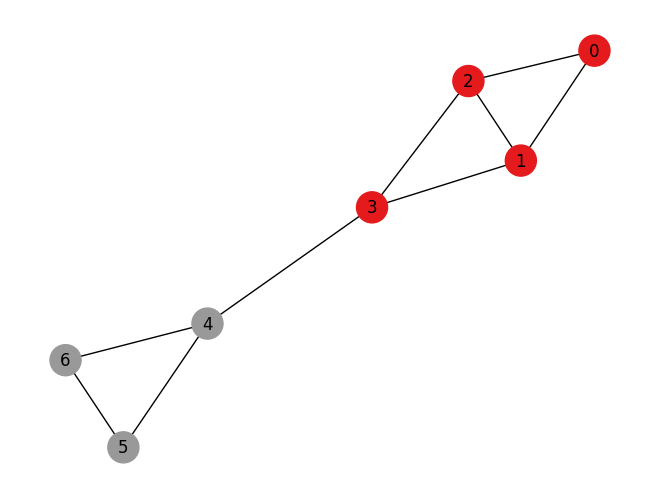

In [32]:
import numpy as np
import networkx as nx
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

# Step 1: Build the Graph
# You can either create the graph manually or load it from your data source.
# For this example, let's create a simple graph.

# Define the edges of the graph (you can adjust these based on your data)
edges = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4), (4, 5), (4, 6), (5, 6)]

# Create an undirected graph
G = nx.Graph()
G.add_edges_from(edges)

# Step 2: Construct the Affinity Matrix
# We'll use the adjacency matrix as the affinity matrix for this example.

# Get the adjacency matrix as a numpy array
adjacency_matrix = nx.to_numpy_array(G)

# Step 3: Compute the Laplacian Matrix
# We'll use the normalized Laplacian for this example.

# Compute the degree matrix (sum of the weights of each node's edges)
degree_matrix = np.diag(np.sum(adjacency_matrix, axis=1))

# Compute the Laplacian matrix
laplacian_matrix = degree_matrix - adjacency_matrix

# Step 4: Compute Eigenvalues and Eigenvectors
# Use numpy's linalg.eig function to compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(laplacian_matrix)

# Step 5: Form a New Feature Representation
# We'll use the first k eigenvectors as our new feature representation.
# Choose the number of clusters (k) you want to identify.
k = 2
idx = np.argsort(eigenvalues)[0:k]
new_features = eigenvectors[:, idx]

# Step 6: Clustering
# Use k-means clustering on the new feature representation
spectral_clustering = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', n_neighbors=4, assign_labels='kmeans')
predicted_labels = spectral_clustering.fit_predict(new_features)

# Plot the graph with node colors based on the clustering result
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=predicted_labels, cmap=plt.cm.Set1, node_size=500)
plt.show()


### Comparison between Shi and Malik - Normalized Spectral Clustering

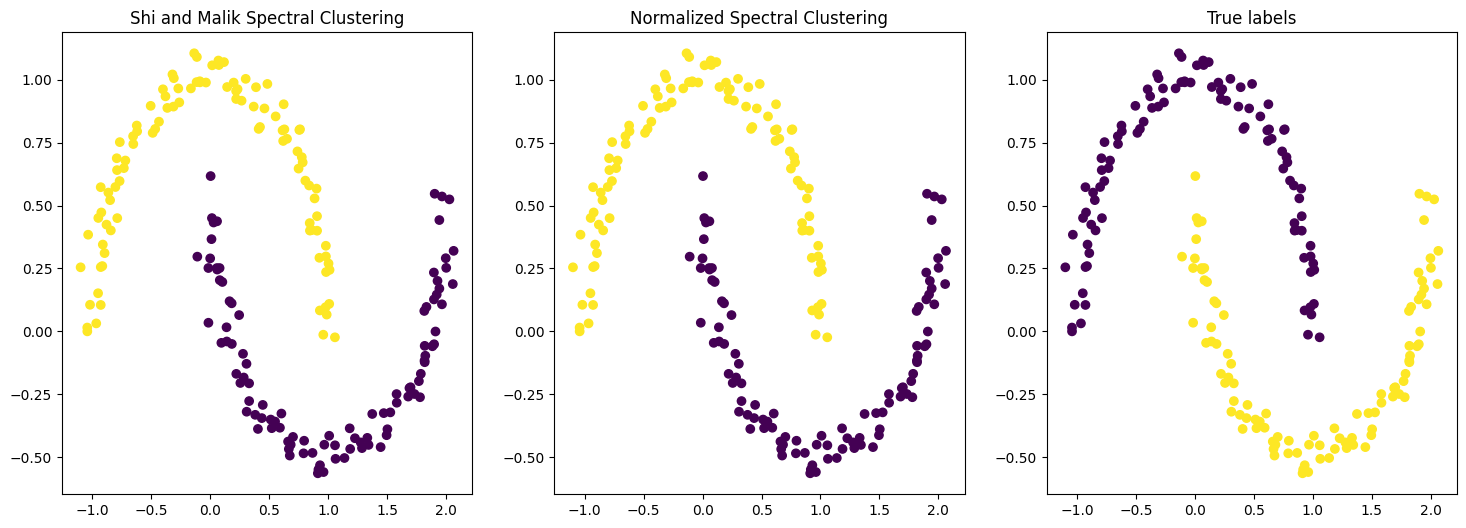

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigs

# Generate a synthetic dataset (two moons)
X, y = make_moons(n_samples=200, noise=0.05, random_state=42)

# Create a similarity graph using k-nearest neighbors
graph = kneighbors_graph(X, n_neighbors=10, mode='connectivity', include_self=True)

# Spectral clustering using Shi and Malik algorithm
def shi_malik_spectral_clustering(graph, n_clusters):
    # Compute the graph Laplacian matrix
    laplacian_matrix = graph - np.diag(np.array(graph.sum(axis=1)).flatten())

    # Compute the first n_clusters eigenvectors of the Laplacian matrix
    _, eigenvectors = eigs(laplacian_matrix, k=n_clusters, which='SM')

    # Use K-means to cluster the eigenvectors
    kmeans = KMeans(n_clusters=n_clusters,random_state=42)
    kmeans.fit(eigenvectors.real)
    return kmeans.labels_

# Spectral clustering using normalized spectral clustering (Ng-Jordan-Weiss)
def normalized_spectral_clustering(graph, n_clusters):
    # Compute the graph Laplacian matrix
    laplacian_matrix = graph - np.diag(np.array(graph.sum(axis=1)).flatten())

    # Compute the normalized Laplacian matrix
    normalized_laplacian = np.linalg.inv(np.diag(np.array(graph.sum(axis=1)).flatten())) @ laplacian_matrix

    # Compute the first n_clusters eigenvectors of the normalized Laplacian matrix
    _, eigenvectors = eigs(normalized_laplacian, k=n_clusters + 1, which='SM')

    # Use K-means to cluster the eigenvectors
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(eigenvectors[:, 1:].real)
    return kmeans.labels_

# Number of clusters (we know it's 2 for this dataset)
n_clusters = 2

# Perform Shi and Malik spectral clustering
shi_malik_labels = shi_malik_spectral_clustering(graph, n_clusters)

# Perform normalized spectral clustering (Ng-Jordan-Weiss)
normalized_labels = normalized_spectral_clustering(graph, n_clusters)

# Visualize the results
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1], c=shi_malik_labels, cmap='viridis')
plt.title('Shi and Malik Spectral Clustering')
plt.subplot(1, 3, 2)
plt.scatter(X[:, 0], X[:, 1], c=normalized_labels, cmap='viridis')
plt.title('Normalized Spectral Clustering')
plt.subplot(1, 3, 3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.title('True labels')
plt.show()


### Reproducing third case

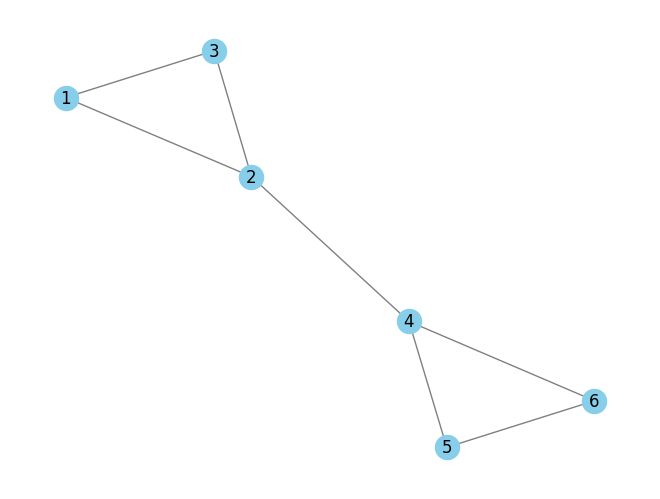

Nodes in the connected subgraph: [1, 2, 3, 4, 5, 6]
Edges in the connected subgraph: [(1, 2), (1, 3), (2, 3), (2, 4), (4, 5), (4, 6), (5, 6)]


In [85]:
import networkx as nx

# Create an example graph (replace this with your actual graph)
# For this example, we'll use an undirected graph
G = nx.Graph()
G.add_edges_from([(1, 2), (1, 3), (2, 3), (2, 4), (4, 5),(5,6),(6,4)])
nx.draw(G,with_labels=True,node_color="skyblue", edge_color="gray")
plt.show()

# Function to generate the connected subgraph from a given graph
def generate_connected_subgraph(graph, start_node):
    visited_nodes = set()
    queue = [start_node]
    while queue:
        node = queue.pop(0)
        if node not in visited_nodes:
            visited_nodes.add(node)
            neighbors = list(graph.neighbors(node))
            queue.extend(neighbors)
    subgraph_nodes = visited_nodes
    subgraph = graph.subgraph(subgraph_nodes)
    return subgraph

# Call the function with the start_node you want to begin the connected subgraph from
start_node = 1  # Replace this with the desired starting node
connected_subgraph = generate_connected_subgraph(G, start_node)

# Print the nodes and edges of the connected subgraph
print("Nodes in the connected subgraph:", connected_subgraph.nodes())
print("Edges in the connected subgraph:", connected_subgraph.edges())


# NOT WORKING

## From processed
Are these speed and acceleration values? why are they 20 cols and not 60 (20 markers x 3 dims) ? Are these magnitudes?

In [46]:
# Questo non ha senso
DATA_POSITION_PATH = "data/derivated_orig/07-07/t_051/t_051_ACCELERATION.txt"
table = pd.read_table(DATA_POSITION_PATH,header=None,sep=' ')
#needRotation = True
table.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.00,0.003027,0.001672,0.000601,-0.000017,-0.000013,0.000750,0.002242,0.004252,0.006413,...,-0.002697,-0.002618,-0.001668,-0.000226,0.001307,0.002535,0.003224,0.003379,0.003112,0.002578
1,0.01,0.005455,0.003104,0.001259,0.000219,0.000280,0.001689,0.004388,0.007996,0.011840,...,-0.005426,-0.005077,-0.003000,0.000119,0.003537,0.006486,0.008437,0.009250,0.009030,0.008120
2,0.02,0.008882,0.005397,0.002703,0.001269,0.001563,0.003981,0.008426,0.014264,0.020360,...,-0.010984,-0.009786,-0.005258,0.001468,0.009127,0.016302,0.021794,0.024903,0.025494,0.024317
3,0.03,0.009054,0.006258,0.004175,0.003249,0.003956,0.006689,0.011337,0.017215,0.023078,...,-0.016168,-0.013854,-0.007000,0.003156,0.015157,0.027187,0.037351,0.044079,0.046711,0.046378
4,0.04,0.005969,0.005397,0.005106,0.005333,0.006409,0.008588,0.011757,0.015389,0.018543,...,-0.019358,-0.016389,-0.008284,0.003837,0.018590,0.034063,0.047932,0.057983,0.063147,0.064739


## From raw

In [42]:
import pandas as pd

DATA_RAW_PATH = "data/raw/"
MURIEL_RAW = DATA_RAW_PATH+"muriel/"
MARIANNE_RAW = DATA_RAW_PATH+"marianne/"
CORA_RAW = DATA_RAW_PATH+"cora/"
JUL_SEV_RAW = DATA_RAW_PATH+"07-07/"
JUL_EI_RAW = DATA_RAW_PATH+"07-08/"
JUL_THI_RAW = DATA_RAW_PATH+"07-13/"

drive_raw_map = {   1:  (MURIEL_RAW+"t_003.tsv",(37,40)),
                    2:  (MURIEL_RAW+"t_003.tsv",(58,64)),
                    3:  (MURIEL_RAW+"t_003.tsv",(73,76)),
                    4:  (MURIEL_RAW+"t_004.tsv",(13,16)),
                    5:  (MARIANNE_RAW+"t_002.tsv",(36.3,41.5)),
                    6:  (MARIANNE_RAW+"t_002.tsv",(44.4,50)),
                    7:  (MARIANNE_RAW+"t_003.tsv",(3,8.9)),
                    8:  (MARIANNE_RAW+"t_005.tsv",(4,9)),
                    9:  (MARIANNE_RAW+"t_005.tsv",(9.2,13.4)),
                    10: (MARIANNE_RAW+"t_012.tsv",(14,20.1)),
                    11: (CORA_RAW+"t_028.tsv",(4.7,8.3)),
                    12: (CORA_RAW+"t_028.tsv",(12.8,18.5)),
                    13: (CORA_RAW+"t_028.tsv",(24.2,29.7)),
                    14: (CORA_RAW+"t_028.tsv",(29.8,36.2)),
                    15: (CORA_RAW+"t_028.tsv",(51.1,55)),
                    16: (CORA_RAW+"t_028.tsv",(57.9,63.8)),
                    17: (JUL_SEV_RAW+"t_051.tsv",(16.9,18.7)),
                    18: (JUL_SEV_RAW+"t_052.tsv",(11.5,13.2)),
                    19: (JUL_SEV_RAW+"t_052.tsv",(15,18)),
                    20: (JUL_SEV_RAW+"t_052.tsv",(19,21.5)),
                    21: (JUL_SEV_RAW+"t_060.tsv",(2,5)),
                    22: (JUL_SEV_RAW+"t_061.tsv",(58,61)),
                    23: (JUL_SEV_RAW+"t_063.tsv",(25.5,28.5)),    
                    24: (JUL_SEV_RAW+"t_064.tsv",(2.5,5.5)),    
                    25: (JUL_EI_RAW+"t_052.tsv",(8.1,11.8)),    # A   
                    26: (JUL_EI_RAW+"t_052.tsv",(11.8,15.1)),   # B   
                    27: (JUL_EI_RAW+"t_052.tsv",(12.15,14.7)),  # A         
                    28: (JUL_EI_RAW+"t_052.tsv",(8.5,11.8)),    # B       
                    29: (JUL_EI_RAW+"t_053.tsv",(22,24.5)),     # A  
                    30: (JUL_EI_RAW+"t_053.tsv",(22,24.5)),     # B      
                    31: (JUL_EI_RAW+"t_053.tsv",(25,27.2)),     # A     
                    32: (JUL_EI_RAW+"t_053.tsv",(25,27.2)),     # B   
                    33: (JUL_THI_RAW+"t_061.tsv",(29,32.1)), # A      
                    34: (JUL_THI_RAW+"t_061.tsv",(29,32.1)), # B       
                    35: (JUL_THI_RAW+"t_061.tsv",(74,80)),   # A 
                    36: (JUL_THI_RAW+"t_061.tsv",(74,80))    # B      
                    }


data = pd.read_csv(drive_raw_map[1][0], sep='\t',skiprows=10,low_memory=False)
data.head()

,Frame,Time,SMPTE,ARIEL X,ARIEL Y,ARIEL Z,LFHD X,LFHD Y,LFHD Z,RFHD X,...,RBHD X,RBHD Y,RBHD Z,LBHD X,LBHD Y,LBHD Z,LPLM X,LPLM Y,LPLM Z,Unnamed: 189
0,1,0.00000,00:34:38.17:01,915.832,1636.494,-102.556,860.323,1594.619,-35.402,877.048,...,978.740,1481.155,-155.687,975.891,1501.635,-14.070,962.765,1354.705,679.482,NaN
1,2,0.01042,00:34:38.17:02,915.833,1636.502,-102.572,860.359,1594.634,-35.406,877.051,...,978.740,1481.176,-155.698,975.945,1501.673,-14.085,962.826,1354.702,679.471,NaN
2,3,0.02083,00:34:38.17:03,915.849,1636.510,-102.606,860.385,1594.632,-35.414,877.072,...,978.776,1481.168,-155.703,975.970,1501.698,-14.092,962.879,1354.709,679.464,NaN
3,4,0.03125,00:34:38.18:00,915.765,1636.592,-102.680,860.628,1594.947,-35.348,877.593,...,979.312,1480.932,-155.603,976.193,1502.154,-14.207,962.849,1354.905,679.555,NaN
4,5,0.04167,00:34:38.18:01,915.807,1636.588,-102.680,860.487,1594.766,-35.691,877.511,...,979.331,1480.824,-155.588,976.034,1502.055,-14.083,962.898,1354.968,679.470,NaN


In [43]:
data = data.iloc[:,3:]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14770 entries, 0 to 14769
Columns: 187 entries, ARIEL X to Unnamed: 189
dtypes: float64(130), object(57)
memory usage: 21.1+ MB


## From processed split
BAD LOOKING SHAPES...

In [44]:
import pandas as pd

DATA_PROCESSED_PATH = "data/processed/"
MURIEL_PROCESSED = DATA_PROCESSED_PATH+"muriel/"
MARIANNE_PROCESSED = DATA_PROCESSED_PATH+"marianne/"
CORA_PROCESSED = DATA_PROCESSED_PATH+"cora/"
JUL_SEV_PROCESSED = DATA_PROCESSED_PATH+"07-07/"
JUL_EI_PROCESSED = DATA_PROCESSED_PATH+"07-08/"
JUL_THI_PROCESSED = DATA_PROCESSED_PATH+"07-13/"

drive_processed_map = { 1:  (MURIEL_PROCESSED+"t_003/t_003",(37,40)),
                        2:  (MURIEL_PROCESSED+"t_003/t_003",(58,64)),
                        3:  (MURIEL_PROCESSED+"t_003/t_003",(73,76)),
                        4:  (MURIEL_PROCESSED+"t_004/t_004",(13,16)),
                        5:  (MARIANNE_PROCESSED+"t_002/t_002",(36.3,41.5)),
                        6:  (MARIANNE_PROCESSED+"t_002/t_002",(44.4,50)),
                        7:  (MARIANNE_PROCESSED+"t_003/t_003",(3,8.9)),
                        8:  (MARIANNE_PROCESSED+"t_005/t_005",(4,9)),
                        9:  (MARIANNE_PROCESSED+"t_005/t_005",(9.2,13.4)),
                        10: (MARIANNE_PROCESSED+"t_012/t_012",(14,20.1)),
                        11: (CORA_PROCESSED+"t_028",(4.7,8.3)),
                        12: (CORA_PROCESSED+"t_028",(12.8,18.5)),
                        13: (CORA_PROCESSED+"t_028",(24.2,29.7)),
                        14: (CORA_PROCESSED+"t_028",(29.8,36.2)),
                        15: (CORA_PROCESSED+"t_028",(51.1,55)),
                        16: (CORA_PROCESSED+"t_028",(57.9,63.8)),
                        17: (JUL_SEV_PROCESSED+"t_051/t_051",(16.9,18.7)),
                        18: (JUL_SEV_PROCESSED+"t_052/t_052",(11.5,13.2)),
                        19: (JUL_SEV_PROCESSED+"t_052/t_052",(15,18)),
                        20: (JUL_SEV_PROCESSED+"t_052/t_052",(19,21.5)),
                        21: (JUL_SEV_PROCESSED+"t_060/t_060",(2,5)),
                        22: (JUL_SEV_PROCESSED+"t_061/t_061",(58,61)),
                        23: (JUL_SEV_PROCESSED+"t_063/t_063",(25.5,28.5)),
                        24: (JUL_SEV_PROCESSED+"t_064/t_064",(2.5,5.5)),
                        25: (JUL_EI_PROCESSED+"t_052/A/t_052_A",(8.1,11.8)),       
                        26: (JUL_EI_PROCESSED+"t_052/B/t_052_B",(11.8,15.1)),      
                        27: (JUL_EI_PROCESSED+"t_052/A/t_052_A",(12.15,14.7)),     
                        28: (JUL_EI_PROCESSED+"t_052/B/t_052_B",(8.5,11.8)),       
                        29: (JUL_EI_PROCESSED+"t_053/A/t_053_A",(22,24.5)),
                        30: (JUL_EI_PROCESSED+"t_053/B/t_053_B",(22,24.5)),        
                        31: (JUL_EI_PROCESSED+"t_053/A/t_053_A",(25,27.2)),        
                        32: (JUL_EI_PROCESSED+"t_053/B/t_053_B",(25,27.2)),        
                        33: (JUL_THI_PROCESSED+"t_061/A/t_061_A",(29,32.1)),       
                        34: (JUL_THI_PROCESSED+"t_061/B/t_061_B",(29,32.1)),        
                        35: (JUL_THI_PROCESSED+"t_061/A/t_061_A",(74,80)),
                        36: (JUL_THI_PROCESSED+"t_061/B/t_061_B",(74,80))         
                    }


tableX = pd.DataFrame()
tableY = pd.DataFrame()
tableZ = pd.DataFrame()

dtypes = {'X': float, 'Y': float, 'Z': float}

for i in range(1,21):
    data = pd.read_csv(drive_processed_map[1][0]+"_split_"+str(i)+"_out.txt",skiprows=1,sep=',',header=None,dtype=dtypes)
    tableX = pd.concat([tableX,data[0]],axis=1)
    tableY = pd.concat([tableY,data[1]],axis=1)
    tableZ = pd.concat([tableZ,data[2]],axis=1)
tableX.head()
#table = data
print(tableX.info())
print(tableY.info())
print(tableZ.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14770 entries, 0 to 14769
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       14770 non-null  float64
 1   0       14770 non-null  float64
 2   0       14770 non-null  float64
 3   0       14770 non-null  float64
 4   0       14770 non-null  float64
 5   0       14770 non-null  float64
 6   0       14770 non-null  float64
 7   0       14770 non-null  float64
 8   0       14770 non-null  float64
 9   0       14770 non-null  float64
 10  0       14770 non-null  float64
 11  0       14770 non-null  float64
 12  0       14770 non-null  float64
 13  0       14770 non-null  float64
 14  0       14770 non-null  float64
 15  0       14770 non-null  float64
 16  0       14770 non-null  float64
 17  0       14770 non-null  float64
 18  0       14770 non-null  float64
 19  0       14770 non-null  float64
dtypes: float64(20)
memory usage: 2.3 MB
None
<class 'pandas.core.frame.DataF

In [45]:
from matplotlib import pyplot as plt
%matplotlib
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


plt.close("all")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#tableNoTime = table.iloc[:,1:]
#timeCol = table.iloc[:,0]
#if needRotation:
#    tableX = tableNoTime.iloc[:,::3]
#    tableZ = tableNoTime.iloc[:,1::3]
#    tableY = tableNoTime.iloc[:,2::3]
#else:
#    tableX = tableNoTime.iloc[:,::3]
#    tableY = tableNoTime.iloc[:,1::3]
#    tableZ = tableNoTime.iloc[:,2::3]

#theta = np.pi/2  # 90 degrees in radians
#R = np.array([[np.cos(theta), -np.sin(theta), 0],
#              [np.sin(theta), np.cos(theta), 0],
#              [0, 0, 1]])
#
#for i in range(len(tableX)):
#    # Apply the rotation matrix to the data
#    data_st = np.vstack([tableX[i,:], tableY[i,:], tableZ[i,:]])
#    data_rotated = np.dot(data_st, R)
#    tableX[i,:]=data_rotated[0,:]
#    tableY[i,:]=data_rotated[1,:]
#    tableZ[i,:]=data_rotated[2,:]    
#tableX = data_rotated[:,0]
#tableY = data_rotated[:,1]
#tableZ = data_rotated[:,2]

minMax = np.zeros((2,3))
minMax[0,:] = [tableX.values.min(),tableY.values.min(),tableZ.values.min()]
minMax[1,:] = [tableX.values.max(),tableY.values.max(),tableZ.values.max()]

print(minMax)

# Set appropriate axis limits
ax.set_xlim([minMax[0,0],minMax[1,0]])
ax.set_ylim([minMax[0,1],minMax[1,1]])
ax.set_zlim([minMax[0,2],minMax[1,2]])

# Set the initial time index
time_index = 0

# Function to update the plot based on the slider value
def update_plot(val):
    ax.cla()  # Clear the previous plot
    
    # Filter the data based on the current time index
    filteredX = tableX.iloc[val]
    filteredY = tableY.iloc[val]
    filteredZ = tableZ.iloc[val]
    
    ax.scatter(filteredX,filteredY,filteredZ)

    ax.set_xlim([minMax[0,0],minMax[1,0]])
    ax.set_ylim([minMax[0,1],minMax[1,1]])
    ax.set_zlim([minMax[0,2],minMax[1,2]])
    
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)
    ax.set_title('3D Movement')

    fig.canvas.draw_idle()

# Create a slider widget
slider_ax = plt.axes([0.2, 0.03, 0.6, 0.03])
slider = Slider(slider_ax, 'TimeIndex', 0, tableX.shape[0]-1, valinit=time_index, valstep=1)

# Register the update_plot function with the slider widget
slider.on_changed(update_plot)

# Initial plot
update_plot(time_index)

# Show the plot
plt.show()


Using matplotlib backend: TkAgg
[[-0.09629714 -0.0039084  -0.89798571]
 [ 1.69142434  2.0124404   2.4209322 ]]
